# Projeto prático FT045B II
## Autor: Bruno Ricardo Corrêa

Os dados obtidos no estudo NHANES (2021-2023) estavam separados em diferentes datasets, para que fosse possível utilizar para o treinamento de models de Aprendizado de Máquina, foi necessário fazer uma união dos mesmos, para melhor organização o procedimento de preparar o dataset foi feito em um Notebook a parte:
[Notebook de Preparação do Dataset](https://colab.research.google.com/drive/1ER1DUe7lbgODe1OANINtZaC5eA9mSM72?usp=sharing)

---



## Importação de Bibliotecas

In [107]:
# Install libs with pip
# %pip install scikit-learn pandas matplotlib notebook imbalanced-learn jupyter xgboost # For CPU-Only version of xgboost

# Install libs with conda
%conda install -c conda-forge scikit-learn pandas matplotlib notebook imbalanced-learn jupyter xgboost cudatoolkit # For GPU version of xgboost

2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [108]:
%pip install aif360 shap lime

Note: you may need to restart the kernel to use updated packages.


In [109]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
# Importing helpers, metrics e and models
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imports de ML
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
# Pipeline e models Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, \
    roc_auc_score
from scipy.stats import uniform, randint

# Imports para SMOTE e o Pipeline correto
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Importante! Use o Pipeline do imblearn
from aif360.sklearn import metrics as mt
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
import shap
import lime
import lime.lime_tabular


## Carregamento do dataset e análise exploratória


In [110]:
# Read the dataset
cvd_df = pd.read_csv('nhanes_2021_2023_merged_data.csv')

In [111]:
cvd_df.head()

SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0  130378.0      12.0       2.0       1.0      43.0       NaN       5.0   
1  130379.0      12.0       2.0       1.0      66.0       NaN       3.0   
2  130380.0      12.0       2.0       2.0      44.0       NaN       2.0   
3  130384.0      12.0       1.0       1.0      43.0       NaN       1.0   
4  130385.0      12.0       1.0       2.0      65.0       NaN       3.0   

   RIDRETH3  RIDEXMON  RIDEXAGM  ...  MCQ230D  OSQ230       PAD790Q  PAD790U  \
0       6.0       2.0       NaN  ...      NaN     2.0  3.000000e+00     b'W'   
1       3.0       2.0       NaN  ...      NaN     1.0  4.000000e+00     b'W'   
2       2.0       1.0       NaN  ...      NaN     1.0  1.000000e+00     b'W'   
3       1.0       NaN       NaN  ...      NaN     2.0  5.397605e-79      b''   
4       3.0       NaN       NaN  ...      NaN     2.0  1.000000e+00     b'D'   

   PAD800       PAD810Q  PAD810U  PAD820  PAD680  target  
0    45.0  3.000000e+00     b'W'    45.0   360.0       0  
1    45.0  3.000000e+00     b'W'    45.0   480.0       0  
2    20.0  5.397605e-79      b''     NaN   240.0       0  
3     NaN  5.397605e-79      b''     NaN    60.0       0  
4    90.0  1.000000e+00     b'W'    60.0   180.0       0  

[5 rows x 216 columns]

In [112]:
cvd_df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7806 entries, 0 to 7805
Data columns (total 216 columns):
 #    Column    Non-Null Count  Dtype  
---   ------    --------------  -----  
 0    SEQN      7806 non-null   float64
 1    SDDSRVYR  7806 non-null   float64
 2    RIDSTATR  7806 non-null   float64
 3    RIAGENDR  7806 non-null   float64
 4    RIDAGEYR  7806 non-null   float64
 5    RIDAGEMN  0 non-null      float64
 6    RIDRETH1  7806 non-null   float64
 7    RIDRETH3  7806 non-null   float64
 8    RIDEXMON  6062 non-null   float64
 9    RIDEXAGM  0 non-null      float64
 10   DMQMILIZ  7792 non-null   float64
 11   DMDBORN4  7791 non-null   float64
 12   DMDYRUSR  1572 non-null   float64
 13   DMDEDUC2  7792 non-null   float64
 14   DMDMARTZ  7791 non-null   float64
 15   RIDEXPRG  1503 non-null   float64
 16   DMDHHSIZ  7806 non-null   float64
 17   DMDHRGND  0 non-null      float64
 18   DMDHRAGZ  0 non-null      float64
 19   DMDHREDZ  0 non-null      float64
 20   DMDHRM

In [113]:
# Show the dataset statistical metrics
cvd_df.describe()

SEQN  SDDSRVYR     RIDSTATR     RIAGENDR     RIDAGEYR  \
count    7806.000000    7806.0  7806.000000  7806.000000  7806.000000   
mean   136369.366001      12.0     1.776582     1.553549    53.627978   
std      3441.038782       0.0     0.416563     0.497156    17.529460   
min    130378.000000      12.0     1.000000     1.000000    20.000000   
25%    133382.500000      12.0     2.000000     1.000000    38.000000   
50%    136409.000000      12.0     2.000000     2.000000    57.000000   
75%    139336.750000      12.0     2.000000     2.000000    68.000000   
max    142310.000000      12.0     2.000000     2.000000    80.000000   

       RIDAGEMN     RIDRETH1     RIDRETH3     RIDEXMON  RIDEXAGM  ...  \
count       0.0  7806.000000  7806.000000  6062.000000       0.0  ...   
mean        NaN     3.127082     3.312324     1.530683       NaN  ...   
std         NaN     0.984306     1.394625     0.499099       NaN  ...   
min         NaN     1.000000     1.000000     1.000000       NaN  ...   
25%         NaN     3.000000     3.000000     1.000000       NaN  ...   
50%         NaN     3.000000     3.000000     2.000000       NaN  ...   
75%         NaN     3.000000     3.000000     2.000000       NaN  ...   
max         NaN     5.000000     7.000000     2.000000       NaN  ...   

          MCQ230B    MCQ230C  MCQ230D       OSQ230       PAD790Q       PAD800  \
count  159.000000  26.000000      2.0  5721.000000  7.793000e+03  6088.000000   
mean    28.654088  28.230769     66.0     1.708967  5.808662e+01    92.413108   
std      8.714158   7.425942      0.0     0.747540  7.304054e+02   542.882523   
min     10.000000  13.000000     66.0     1.000000  5.397605e-79     1.000000   
25%     23.000000  23.250000     66.0     1.000000  1.000000e+00    30.000000   
50%     32.000000  29.000000     66.0     2.000000  2.000000e+00    45.000000   
75%     34.000000  33.000000     66.0     2.000000  4.000000e+00    60.000000   
max     39.000000  39.000000     66.0     9.000000  9.999000e+03  9999.000000   

            PAD810Q       PAD820        PAD680       target  
count  7.798000e+03  3452.000000  7.797000e+03  7806.000000  
mean   4.901013e+01    96.835747  4.491851e+02     0.112862  
std    6.853329e+02   602.375146  9.301982e+02     0.316444  
min    5.397605e-79     1.000000  5.397605e-79     0.000000  
25%    5.397605e-79    30.000000  1.800000e+02     0.000000  
50%    5.397605e-79    45.000000  3.000000e+02     0.000000  
75%    2.000000e+00    60.000000  4.800000e+02     0.000000  
max    9.999000e+03  9999.000000  9.999000e+03     1.000000  

[8 rows x 213 columns]

In [114]:
# Counts the duplicated lines
cvd_df.duplicated().sum()

np.int64(0)

In [115]:
# Count women (2.0) and men (1.0)
cvd_df['RIAGENDR'].astype(str).map({'2.0': "Feminino", '1.0': "Masculino"}).value_counts()

RIAGENDR
Feminino     4321
Masculino    3485
Name: count, dtype: int64

In [116]:
# Count positive and negative diagnosis
cvd_df['target'].value_counts()

target
0    6925
1     881
Name: count, dtype: int64

# Pré-processamento

### Feature Engineering

In [117]:
# --- Feature Engineering for Smoking ---
smoking_conditions = [
    # Condition 1: Never Smoker
    # If SMQ020 (Smoked 100+ cigs) is 'No' (2)
    (cvd_df['SMQ020'] == 2),

    # Condition 2: Current Daily Smoker
    # If SMQ020 is 'Yes' (1) AND SMQ040 (Smokes now) is 'Every day' (1)
    (cvd_df['SMQ020'] == 1) & (cvd_df['SMQ040'] == 1),

    # Condition 3: Current Occasional Smoker
    # If SMQ020 is 'Yes' (1) AND SMQ040 (Smokes now) is 'Some days' (2)
    (cvd_df['SMQ020'] == 1) & (cvd_df['SMQ040'] == 2),

    # Condition 4: Former Smoker
    # If SMQ020 is 'Yes' (1) AND SMQ040 (Smokes now) is 'Not at all' (3)
    (cvd_df['SMQ020'] == 1) & (cvd_df['SMQ040'] == 3)
]

smoking_choices = [
    'Never Smoker',
    'Current Smoker (Daily)',
    'Current Smoker (Occasional)',
    'Former Smoker'
]

# 'Refused' (7) or 'Don't Know' (9) is marked as missing (None).
cvd_df['smoking'] = np.select(smoking_conditions, smoking_choices, default=None)  # TODO change to NAN

# --- Feature Engineering for Alcohol ---
alcohol_conditions = [
    # Condition 1: Abstainer
    # If ALQ111 (Ever drank) is 'No' (2) OR ALQ121 (How often) is 'Never in last year' (0)
    (cvd_df['ALQ111'] == 2) | (cvd_df['ALQ121'] == 0),

    # Condition 2: Heavy/Frequent Drinker
    # (Codes 1: Every day, 2: Nearly every day, 3: 3-4 times a week)
    (cvd_df['ALQ121'] >= 1) & (cvd_df['ALQ121'] <= 3),

    # Condition 3: Moderate Drinker
    # (Codes 4: 2 times a week, 5: Once a week, 6: 2-3 times a month)
    (cvd_df['ALQ121'] >= 4) & (cvd_df['ALQ121'] <= 6),

    # Condition 4: Occasional Drinker
    # (Codes 7: Once a month, 8: 7-11 times/year, 9: 3-6 times/year, 10: 1-2 times/year)
    (cvd_df['ALQ121'] >= 7) & (cvd_df['ALQ121'] <= 10)
]

alcohol_choices = [
    'Abstainer',
    'Heavy/Frequent Drinker',
    'Moderate Drinker',
    'Occasional Drinker'
]

# 'default=None' handles 'Refused' (7, 77) and 'Don't Know' (9, 99)
cvd_df['alcohol'] = np.select(alcohol_conditions, alcohol_choices, default=None)  # TODO change to NAN

print("\n--- Smoking Categories Created (Value Counts) ---")
# 'dropna=False' includes a count of the 'NaN' (missing) values
print(cvd_df['smoking'].value_counts(dropna=False))

print("\n--- Alcohol Categories Created (Value Counts) ---")
print(cvd_df['alcohol'].value_counts(dropna=False))


--- Smoking Categories Created (Value Counts) ---
smoking
Never Smoker                   4546
Former Smoker                  2049
Current Smoker (Daily)          948
Current Smoker (Occasional)     235
None                             28
Name: count, dtype: int64

--- Alcohol Categories Created (Value Counts) ---
alcohol
None                      3396
Occasional Drinker        1589
Moderate Drinker          1441
Heavy/Frequent Drinker     920
Abstainer                  460
Name: count, dtype: int64


In [118]:
# Assume 'cvd_df' is your fully merged DataFrame
print("Starting physical activity feature engineering...")


# --- 1. Helper Function to Calculate Minutes per Week ---
# This function will read the frequency, unit, and duration columns
# and output a single 'minutes per week' value.

def calculate_weekly_minutes(df, freq_col, unit_col, mins_col):
    """
    Calculates total weekly minutes of activity, normalizing from
    day, week, month, or year entries.
    """

    # Make copies to avoid changing original data
    freq = df[freq_col].copy()
    unit = df[unit_col].copy()
    mins = df[mins_col].copy()

    # Replace special codes (Refused, Don't Know) with NaN
    # This will cause them to be treated as 0 activity later
    freq = freq.replace([7777, 9999], np.nan)
    mins = mins.replace([7777, 9999], np.nan)

    # Calculate total minutes per unit (e.g., 30 mins * 3 times = 90)
    # This will result in NaN if freq, mins, or unit is missing
    total_mins_per_unit = freq * mins

    # --- Normalize to a weekly basis ---

    # Conditions for np.select
    conditions = [
        unit == "b'D'",  # Daily
        unit == "b'W'",  # Weekly
        unit == "b'M'",  # Monthly
        unit == "b'Y'"  # Yearly
    ]

    # Choices for normalization factors
    # How to convert the unit to a weekly value
    choices = [
        total_mins_per_unit * 7,  # (e.g., 20 mins * 3 times/day * 7 days/week)
        total_mins_per_unit * 1,  # (e.g., 90 mins * 1 time/week)
        total_mins_per_unit * (12 / 52),  # (e.g., 300 mins * 2 times/month * (12/52) weeks/month)
        total_mins_per_unit / 52  # (e.g., 5000 mins * 1 time/year / 52 weeks/year)
    ]

    # Apply the conversion
    # default=np.nan ensures anything not D, W, M, Y becomes NaN
    weekly_minutes = np.select(conditions, choices, default=np.nan)

    # **Crucial Step**: Assume missing activity data means 0 activity.
    # We fill with 0 *after* all calculations are done.
    # This converts all NaN (missing, refused, don't know) to 0.
    return pd.Series(weekly_minutes).fillna(0)


# --- 2. Apply the Function to Our DataFrame ---

# Create new columns for total weekly minutes for each intensity
cvd_df['MOD_MIN_PER_WEEK'] = calculate_weekly_minutes(cvd_df, 'PAD790Q', 'PAD790U', 'PAD800')
cvd_df['VIG_MIN_PER_WEEK'] = calculate_weekly_minutes(cvd_df, 'PAD810Q', 'PAD810U', 'PAD820')

print("Weekly minutes calculated.")

# --- 3. Create the Final Category 'physical_activity' ---

# Define the 3-tier conditions based on health guidelines
# We must check in the correct order: Active -> Insufficiently Active -> Inactive
pa_conditions = [
    # Condition 1: Active
    # Meets 150+ min moderate OR 75+ min vigorous
    (cvd_df['MOD_MIN_PER_WEEK'] >= 150) | (cvd_df['VIG_MIN_PER_WEEK'] >= 75),

    # Condition 2: Insufficiently Active
    # Does *some* activity but *not* enough to be 'Active'
    # (We already checked for 'Active', so we just need to see if they do *any* activity)
    (cvd_df['MOD_MIN_PER_WEEK'] > 0) | (cvd_df['VIG_MIN_PER_WEEK'] > 0),

    # Condition 3: Inactive
    # Does 0 moderate AND 0 vigorous activity
    (cvd_df['MOD_MIN_PER_WEEK'] == 0) & (cvd_df['VIG_MIN_PER_WEEK'] == 0)
]

# Define the corresponding choices
pa_choices = [
    'Active',
    'Insufficiently Active',
    'Inactive'
]

# Create the final column
# 'default=None' is a safeguard, but all rows should match one condition
cvd_df['physical_activity'] = np.select(pa_conditions, pa_choices, default=None)  # TODO change to NAN

print("Physical Activity categories created.")

# --- Verification ---
print("\n--- Physical Activity Categories Created (Value Counts) ---")
print(cvd_df['physical_activity'].value_counts(dropna=False))

print("\n--- DataFrame Head with New Columns (Sample) ---")
# Show the new helper columns and the final category
print(cvd_df[['SEQN', 'MOD_MIN_PER_WEEK', 'VIG_MIN_PER_WEEK', 'physical_activity']].head())

cvd_df.drop(columns=['MOD_MIN_PER_WEEK', 'VIG_MIN_PER_WEEK'])


Starting physical activity feature engineering...
Weekly minutes calculated.
Physical Activity categories created.

--- Physical Activity Categories Created (Value Counts) ---
physical_activity
Active                   3657
Insufficiently Active    2509
Inactive                 1640
Name: count, dtype: int64

--- DataFrame Head with New Columns (Sample) ---
       SEQN  MOD_MIN_PER_WEEK  VIG_MIN_PER_WEEK      physical_activity
0  130378.0             135.0             135.0                 Active
1  130379.0             180.0             135.0                 Active
2  130380.0              20.0               0.0  Insufficiently Active
3  130384.0               0.0               0.0               Inactive
4  130385.0             630.0              60.0                 Active


SEQN  SDDSRVYR  RIDSTATR  RIAGENDR  RIDAGEYR  RIDAGEMN  RIDRETH1  \
0     130378.0      12.0       2.0       1.0      43.0       NaN       5.0   
1     130379.0      12.0       2.0       1.0      66.0       NaN       3.0   
2     130380.0      12.0       2.0       2.0      44.0       NaN       2.0   
3     130384.0      12.0       1.0       1.0      43.0       NaN       1.0   
4     130385.0      12.0       1.0       2.0      65.0       NaN       3.0   
...        ...       ...       ...       ...       ...       ...       ...   
7801  142305.0      12.0       2.0       2.0      76.0       NaN       1.0   
7802  142307.0      12.0       2.0       2.0      49.0       NaN       4.0   
7803  142308.0      12.0       2.0       1.0      50.0       NaN       2.0   
7804  142309.0      12.0       2.0       1.0      40.0       NaN       2.0   
7805  142310.0      12.0       2.0       2.0      80.0       NaN       3.0   

      RIDRETH3  RIDEXMON  RIDEXAGM  ...  PAD790U  PAD800       PAD810Q  \
0          6.0       2.0       NaN  ...     b'W'    45.0  3.000000e+00   
1          3.0       2.0       NaN  ...     b'W'    45.0  3.000000e+00   
2          2.0       1.0       NaN  ...     b'W'    20.0  5.397605e-79   
3          1.0       NaN       NaN  ...      b''     NaN  5.397605e-79   
4          3.0       NaN       NaN  ...     b'D'    90.0  1.000000e+00   
...        ...       ...       ...  ...      ...     ...           ...   
7801       1.0       2.0       NaN  ...     b'W'    40.0  5.397605e-79   
7802       4.0       2.0       NaN  ...     b'W'    15.0  5.397605e-79   
7803       2.0       1.0       NaN  ...     b'W'    45.0  5.397605e-79   
7804       2.0       1.0       NaN  ...     b'D'    15.0  5.397605e-79   
7805       3.0       1.0       NaN  ...      b''     NaN  5.397605e-79   

      PAD810U  PAD820  PAD680  target        smoking                 alcohol  \
0        b'W'    45.0   360.0       0  Former Smoker                    None   
1        b'W'    45.0   480.0       0  Former Smoker  Heavy/Frequent Drinker   
2         b''     NaN   240.0       0   Never Smoker      Occasional Drinker   
3         b''     NaN    60.0       0   Never Smoker                    None   
4        b'W'    60.0   180.0       0   Never Smoker                    None   
...       ...     ...     ...     ...            ...                     ...   
7801      b''     NaN   480.0       1   Never Smoker                    None   
7802      b''     NaN   480.0       0  Former Smoker      Occasional Drinker   
7803      b''     NaN   600.0       0   Never Smoker      Occasional Drinker   
7804      b''     NaN   240.0       0   Never Smoker               Abstainer   
7805      b''     NaN   360.0       0  Former Smoker  Heavy/Frequent Drinker   

          physical_activity  
0                    Active  
1                    Active  
2     Insufficiently Active  
3                  Inactive  
4                    Active  
...                     ...  
7801  Insufficiently Active  
7802  Insufficiently Active  
7803  Insufficiently Active  
7804                 Active  
7805               Inactive  

[7806 rows x 219 columns]

In [119]:
column_names = {
    # --- Identifiers & Demographics ---
    'SEQN': 'id',  # Respondent sequence number
    'RIAGENDR': 'gender',  # Gender
    'RIDAGEYR': 'age',  # Age in years at screening
    'RIDRETH1': 'race_ethnicity',  # Race/Hispanic origin
    'DMDBORN4': 'country_of_birth',  # Country of birth
    'DMDEDUC2': 'education_level',  # Education level - Adults 20+
    'DMDMARTZ': 'marital_status',  # Marital status
    'INDFMPIR': 'income_poverty_ratio',  # Annual family income to poverty ratio

    # --- Examination - Vitals & Body Measures ---
    'BPXOSY1': 'systolic_bp',  # Systolic blood pressure - 1st reading (mmHg)
    'BPXODI1': 'diastolic_bp',  # Diastolic blood pressure - 1st reading (mmHg)
    'BPXOPLS1': 'pulse',  # 60 second pulse - 1st reading
    'BPXOSY2': 'systolic_bp',  # Systolic blood pressure - 2nd reading (mmHg)
    'BPXODI2': 'diastolic_bp',  # Diastolic blood pressure - 2nd reading (mmHg)
    'BPXOPLS2': 'pulse',  # 60 second pulse - 2nd reading
    'BPXOSY3': 'systolic_bp',  # Systolic blood pressure - 3rd reading (mmHg)
    'BPXODI3': 'diastolic_bp',  # Diastolic blood pressure - 3rd reading (mmHg)
    'BPXOPLS3': 'pulse',  # 60 second pulse - 3rd reading
    'BMXWT': 'weight_kg',  # Weight (kg)
    'BMXHT': 'height_cm',  # Standing Height (cm)
    'BMXBMI': 'bmi',  # Body Mass Index (kg/m**2)

    # --- Lab - Urine (Kidney) ---
    'URXUMS': 'urine_albumin_mg_dl',  # Urinary albumin (mg/dL)
    'URXUCR': 'urine_creatinine_mg_dl',  # Urinary creatinine (mg/dL)
    'URDACT': 'urine_albumin_creatinine_ratio',  # Urinary albumin-creatinine ratio (mg/g)

    # --- Lab - Lipids & Inflammation ---
    'LBXTLG': 'triglycerides_mg_dl',  # Triglycerides (mg/dL) - from TRIGLY_L file
    'LBDLDLM': 'ldl_cholesterol_mg_dl',  # LDL Cholesterol, Martin-Hopkins (mg/dL)
    'LBDHDD': 'hdl_cholesterol_mg_dl',  # HDL Cholesterol (mg/dL)
    'LBXHSCRP': 'c_reactive_protein_mg_l',  # High-sensitivity C-reactive protein (mg/L)
    'LBXTC': 'total_cholesterol_mg_dl',  # Total cholesterol (mg/dL) - from TCHOL_L file

    # --- Lab - Glucose & Diabetes ---
    'LBXIN': 'insulin_uiu_ml',  # Insulin (uIU/mL)
    'LBXGH': 'glycohemoglobin_pct',  # Glycohemoglobin (A1c) (%)
    'DIQ010': 'diag_diabetes',  # Ever told had diabetes?
    'LBXGLU': 'fasting_glucose_mg_dl',  # Fasting glucose (mg/dL)

    # --- Lab - Biochemistry Panel (BIOPRO_L) ---
    'LBXSCR': 'serum_creatinine_mg_dl',  # Serum creatinine (mg/dL) - Kidney function
    'LBXSGL': 'serum_glucose_mg_dl',  # Serum glucose (random) (mg/dL)
    'LBXSLDSI': 'ldh_u_l',  # Lactate dehydrogenase (LDH) (U/L)
    'LBXSTB': 'total_bilirubin_mg_dl',  # Total bilirubin (mg/dL) - Liver function
    'LBXSCH': 'total_cholesterol_bch_mg_dl',
    # Total cholesterol (mg/dL) - from BIOPRO panel / using this to complete the LBXTC missing values
    'LBXSTR': 'total_triglycerides_bch_mg_dl',
    # Total triglycerides (mg/dL) - from BIOPRO panel / using this to complete the LBXTLG missing values

    # --- Medical Conditions (Questionnaire) ---
    'MCQ160M': 'diag_thyroid_problem',  # Ever told had *another* thyroid problem?
    'MCQ160P': 'diag_copd_emphysema_bronchitis',  # Ever told had COPD, emphysema, or chronic bronchitis?
    'MCQ160L': 'diag_liver_condition',  # Ever told had any liver condition?
    'MCQ170L': 'still_have_liver_condition',  # Do you *still* have a liver condition?
    'MCQ550': 'diag_gallstones',  # Has DR ever said you have gallstones?

    # --- Custom Engineered Columns ---
    'CAT_HYPERTENSION': 'hypertension_category',
    # Custom: 'Hypertension Stage 2', 'Hypertension Stage 1', 'Elevated', 'Normal'
    'CAT_BMI': 'bmi_category',
    # Custom: 'Underweight', 'Normal Weight', 'Overweight', 'Obesity Class 1', 'Obesity Class 2', 'Obesity Class 3'
    'smoking': 'smoking_category',  # Custom: Never, Former, Current (Daily/Occasional)
    'alcohol': 'alcohol_category',  # Custom: Abstainer, Occasional, Moderate, Heavy
    'physical_activity': 'physical_activity_category',  # Custom: Inactive, Insufficiently Active, Active
    'CAT_KIDNEY_DISEASE': 'kidney_disease_category',
    # Custom: 'CKD G1-Normal (eGFR >= 90)', 'CKD G2-Mild (eGFR 60-89)', 'CKD G3-Moderate (eGFR 30-59)', 'CKD G4/G5-Severe/Failure (eGFR < 30)'
    'target': 'target'  # Custom: 1 (has CVD) / 0 (no CVD)
}

# Get only important columns
relevant_columns = ['SEQN', 'RIAGENDR', 'RIDAGEYR', 'RIDRETH1', 'DMDBORN4', 'DMDEDUC2', 'DMDMARTZ', 'INDFMPIR',
                    'BPXOSY1', 'BPXODI1', 'BPXOPLS1', 'BPXOSY2', 'BPXODI2', 'BPXOPLS2', 'BPXOSY3', 'BPXODI3',
                    'BPXOPLS3', 'BMXWT', 'BMXHT', 'BMXBMI', 'URXUMS', 'URXUCR', 'URDACT', 'LBXTLG', 'LBDLDLM', 'LBDHDD',
                    'LBXIN', 'LBXHSCRP', 'LBXGH', 'DIQ010', 'LBXGLU', 'LBXTC', 'MCQ160M', 'MCQ170M', 'MCQ160P',
                    'MCQ160L', 'MCQ170L', 'MCQ550', 'LBXSCR', 'LBXSGL', 'LBXSLDSI', 'LBXSTB', 'LBXSCH', 'LBXSTR',
                    'smoking', 'alcohol', 'physical_activity', 'target']

subset_cvd_df = cvd_df[relevant_columns].copy()

In [120]:
# Fill missing BPXOSY1 with BPXOSY2 and then with BPXOSY3
subset_cvd_df['BPXOSY1'] = subset_cvd_df['BPXOSY1'].fillna(subset_cvd_df['BPXOSY2'])
subset_cvd_df['BPXOSY1'] = subset_cvd_df['BPXOSY1'].fillna(subset_cvd_df['BPXOSY3'])

# Fill missing BPXODI1 with BPXODI2 and then with BPXODI3
subset_cvd_df['BPXODI1'] = subset_cvd_df['BPXODI1'].fillna(subset_cvd_df['BPXODI2'])
subset_cvd_df['BPXODI1'] = subset_cvd_df['BPXODI1'].fillna(subset_cvd_df['BPXODI3'])

# Fill missing BPXOPLS1 with BPXOPLS2 and then with BPXOPLS3
subset_cvd_df['BPXOPLS1'] = subset_cvd_df['BPXOPLS1'].fillna(subset_cvd_df['BPXOPLS2'])
subset_cvd_df['BPXOPLS1'] = subset_cvd_df['BPXOPLS1'].fillna(subset_cvd_df['BPXOPLS3'])

# Drop the original columns used for filling
subset_cvd_df.drop(columns=['BPXOSY2', 'BPXODI2', 'BPXOPLS2', 'BPXOSY3', 'BPXODI3', 'BPXOPLS3'], inplace=True)

In [121]:
# Fill missing 'LBXTC' with 'LBXSCH'
subset_cvd_df['LBXTC'] = subset_cvd_df['LBXTC'].fillna(subset_cvd_df['LBXSCH'])

# Fill missing 'LBXTLG' with 'LBXSTR'
subset_cvd_df['LBXTLG'] = subset_cvd_df['LBXTLG'].fillna(subset_cvd_df['LBXSTR'])

# Drop the original columns used for filling
subset_cvd_df.drop(columns=['LBXSCH', 'LBXSTR'], inplace=True)

In [122]:
# --- 1. Categoria de Hipertensão (CAT_HYPERTENSION) ---
# Baseado nas diretrizes AHA/ACC 2017
# Ordem de verificação: do mais alto ao mais baixo risco
print("Criando categorias de hipertensão...")
bp_conditions = [
    # Estágio 2: (Sistólica >= 140) OU (Diastólica >= 90)
    (subset_cvd_df['BPXOSY1'] >= 140) | (subset_cvd_df['BPXODI1'] >= 90),

    # Estágio 1: (Sistólica 130-139) OU (Diastólica 80-89)
    (subset_cvd_df['BPXOSY1'] >= 130) | (subset_cvd_df['BPXODI1'] >= 80),

    # Elevada: (Sistólica 120-129) E (Diastólica < 80)
    (subset_cvd_df['BPXOSY1'] >= 120) & (subset_cvd_df['BPXODI1'] < 80),

    # Normal: (Sistólica < 120) E (Diastólica < 80)
    (subset_cvd_df['BPXOSY1'] < 120) & (subset_cvd_df['BPXODI1'] < 80)
]
bp_choices = [
    'Hypertension Stage 2',
    'Hypertension Stage 1',
    'Elevated',
    'Normal'
]  # TODO: Change to numbers and apply the explanation as a comment
subset_cvd_df['CAT_HYPERTENSION'] = np.select(bp_conditions, bp_choices, default=None)

# --- 2. Categoria de IMC (CAT_BMI) ---
# Baseado nas categorias da OMS/CDC
print("Criando categorias de IMC...")
bmi_conditions = [
    (subset_cvd_df['BMXBMI'] < 18.5),
    (subset_cvd_df['BMXBMI'] >= 18.5) & (subset_cvd_df['BMXBMI'] < 25),
    (subset_cvd_df['BMXBMI'] >= 25) & (subset_cvd_df['BMXBMI'] < 30),
    (subset_cvd_df['BMXBMI'] >= 30) & (subset_cvd_df['BMXBMI'] < 35),
    (subset_cvd_df['BMXBMI'] >= 35) & (subset_cvd_df['BMXBMI'] < 40),
    (subset_cvd_df['BMXBMI'] >= 40)
]
bmi_choices = [
    'Underweight',
    'Normal Weight',
    'Overweight',
    'Obesity Class 1',
    'Obesity Class 2',
    'Obesity Class 3'
]  # TODO: Change to numbers and apply the explanation as a comment
subset_cvd_df['CAT_BMI'] = np.select(bmi_conditions, bmi_choices, default=None)

# --- 3. Ratios de Lipídios ---
print("Calculando ratios de lipídios...")
# Relação Colesterol Total / HDL
subset_cvd_df['ratio_chol_hdl'] = subset_cvd_df['LBXTC'] / subset_cvd_df['LBDLDLM']

# Relação Triglicerídeos / HDL
subset_cvd_df['ratio_trig_hdl'] = subset_cvd_df['LBXTLG'] / subset_cvd_df['LBDLDLM']

# Substitui 'inf' por 'NaN' caso 'LBDLDLM' fosse 0
subset_cvd_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# --- 4. eGFR (Função Renal) e Categoria ---
# Usando a fórmula CKD-EPI 2021 (que remove o coeficiente de raça)
print("Calculando eGFR (Função Renal)...")

# Precisamos dos valores de 'gender' (1=Male, 2=Female) e 'LBXSCR'
creatinine = subset_cvd_df['LBXSCR']
age = subset_cvd_df['RIDAGEYR']

# Definir kappa (κ) e alpha (α) com base no gênero (1=Male, 2=Female)
kappa = np.where(subset_cvd_df['RIAGENDR'] == 2, 0.7, 0.9)  # 0.7 para F, 0.9 para M
alpha = np.where(subset_cvd_df['RIAGENDR'] == 2, -0.241, -0.302)  # -0.241 para F, -0.302 para M

# Termo de gênero
gender_term = np.where(subset_cvd_df['RIAGENDR'] == 2, 1.012, 1.0)  # 1.012 para F, 1.0 para M

# Cálculo da eGFR
cr_over_kappa = (creatinine / kappa)
min_term = np.minimum(cr_over_kappa, 1.0) ** alpha
max_term = np.maximum(cr_over_kappa, 1.0) ** -1.200
age_term = 0.9938 ** age

subset_cvd_df['eGFR_2021'] = 142 * min_term * max_term * age_term * gender_term

# Criar categoria de Doença Renal Crônica (DRC)
# Estágios CKD G: G1(>=90), G2(60-89), G3(30-59), G4(15-29), G5(<15)
# Risco cardiovascular aumenta significativamente < 60
print("Criando categorias de doença renal...")
egfr_conditions = [
    (subset_cvd_df['eGFR_2021'] >= 90),
    (subset_cvd_df['eGFR_2021'] >= 60) & (subset_cvd_df['eGFR_2021'] < 90),
    (subset_cvd_df['eGFR_2021'] >= 30) & (subset_cvd_df['eGFR_2021'] < 60),
    (subset_cvd_df['eGFR_2021'] < 30)
]
egfr_choices = [
    'CKD G1-Normal (eGFR >= 90)',
    'CKD G2-Mild (eGFR 60-89)',
    'CKD G3-Moderate (eGFR 30-59)',  # Risco de CVD elevado
    'CKD G4/G5-Severe/Failure (eGFR < 30)'  # Risco de CVD muito elevado
]  # TODO: Change to numbers and apply the explanation as a comment
subset_cvd_df['CAT_KIDNEY_DISEASE'] = np.select(egfr_conditions, egfr_choices, default=None)

# --- 5. Verificação Final ---
print("\n--- Engenharia Avançada de Features Concluída ---")
print("\n--- Novas Colunas Criadas ---")
print(subset_cvd_df[['CAT_HYPERTENSION', 'CAT_BMI', 'ratio_chol_hdl', 'ratio_trig_hdl', 'eGFR_2021',
                     'CAT_KIDNEY_DISEASE']].head())

print("\n--- Informação Final do DataFrame ---")
subset_cvd_df.info()

# Drop columns used to create features from engineering them
subset_cvd_df.drop(columns=['BPXOSY1', 'BPXODI1', 'LBXTC', 'LBXTLG', 'LBDLDLM', 'LBXSCR', 'eGFR_2021'], inplace=True)

Criando categorias de hipertensão...
Criando categorias de IMC...
Calculando ratios de lipídios...
Calculando eGFR (Função Renal)...
Criando categorias de doença renal...

--- Engenharia Avançada de Features Concluída ---

--- Novas Colunas Criadas ---
       CAT_HYPERTENSION          CAT_BMI  ratio_chol_hdl  ratio_trig_hdl  \
0  Hypertension Stage 2       Overweight        1.389474        0.805263   
1  Hypertension Stage 1  Obesity Class 1        1.585185        0.637037   
2                Normal       Overweight        2.077778        4.166667   
3                  None             None             NaN             NaN   
4                  None             None             NaN             NaN   

    eGFR_2021          CAT_KIDNEY_DISEASE  
0  112.614180  CKD G1-Normal (eGFR >= 90)  
1   97.975999  CKD G1-Normal (eGFR >= 90)  
2  111.687296  CKD G1-Normal (eGFR >= 90)  
3         NaN                        None  
4         NaN                        None  

--- Informação Final do D

In [123]:
# Assume 'subset_cvd_df' is your current working DataFrame

print("--- Starting Liver Condition Feature Engineering ---")

# --- 1. Composite Liver Condition Status (Questionnaire based) ---
# We want to combine:
# - diag_liver_condition (MCQ160L): 1=Yes, 2=No
# - still_have_liver_condition (MCQ170L): 1=Yes, 2=No
# into a single ordinal risk feature: 0=Never, 1=Former, 2=Active

print("Creating composite 'LIVER_CONDITION_STATUS'...")
liver_conditions = [
    # Condition 0: Never Diagnosed
    (subset_cvd_df['MCQ160L'] == 2),

    # Condition 1: Former (Diagnosed YES, Still Have NO)
    (subset_cvd_df['MCQ160L'] == 1) & (subset_cvd_df['MCQ170L'] == 2),

    # Condition 2: Active (Still Have YES)
    # Note: If they say they "still have" it, they must have been diagnosed,
    # but we check MCQ170L=1 directly to be safe.
    (subset_cvd_df['MCQ170L'] == 1)
]
liver_choices = [0, 1, 2]  # 0=Never, 1=Former, 2=Active

subset_cvd_df['LIVER_CONDITION_STATUS'] = np.select(liver_conditions, liver_choices).astype(int)

# --- 2. Bilirubin Risk Category (Biomarker based) ---
# Normal range for Total Bilirubin is typically 0.1 to 1.2 mg/dL.
# Levels > 1.2 indicate possible liver dysfunction (Hyperbilirubinemia).
# Levels > 2.0-2.5 often result in visible jaundice and indicate more severe issues.

print("Creating 'CAT_BILIRUBIN' (Biomarker Risk)...")
bilirubin_conditions = [
    (subset_cvd_df['LBXSTB'] <= 1.2),  # Normal
    (subset_cvd_df['LBXSTB'] > 1.2) & (subset_cvd_df['LBXSTB'] <= 2.0),  # Mildly Elevated
    (subset_cvd_df['LBXSTB'] > 2.0)  # Highly Elevated (Jaundice likely)
]
bilirubin_choices = [0, 1, 2]  # Ordinal encoding: 0=Normal, 1=Mild, 2=High

subset_cvd_df['CAT_BILIRUBIN'] = np.select(bilirubin_conditions, bilirubin_choices).astype(int)

# --- Verification ---
print("\n--- Liver Features Created ---")
print(subset_cvd_df[['LIVER_CONDITION_STATUS', 'LBXSTB', 'CAT_BILIRUBIN']].head(10))

print("\n--- Value Counts for New Liver Features ---")
print("Liver Status (0=Never, 1=Former, 2=Active):\n",
      subset_cvd_df['LIVER_CONDITION_STATUS'].value_counts(dropna=False).sort_index())
print("\nBilirubin Cat (0=Normal, 1=Mild, 2=High):\n",
      subset_cvd_df['CAT_BILIRUBIN'].value_counts(dropna=False).sort_index())

# Drop columns used to create features from engineering them
subset_cvd_df.drop(columns=['MCQ160L', 'MCQ170L', 'LBXSTB'], inplace=True)

--- Starting Liver Condition Feature Engineering ---
Creating composite 'LIVER_CONDITION_STATUS'...
Creating 'CAT_BILIRUBIN' (Biomarker Risk)...

--- Liver Features Created ---
   LIVER_CONDITION_STATUS  LBXSTB  CAT_BILIRUBIN
0                       0     0.7              0
1                       0     0.7              0
2                       0     0.6              0
3                       0     NaN              0
4                       0     NaN              0
5                       0     0.5              0
6                       0     0.3              0
7                       0     NaN              0
8                       0     NaN              0
9                       0     0.2              0

--- Value Counts for New Liver Features ---
Liver Status (0=Never, 1=Former, 2=Active):
 LIVER_CONDITION_STATUS
0    7436
1     127
2     243
Name: count, dtype: int64

Bilirubin Cat (0=Normal, 1=Mild, 2=High):
 CAT_BILIRUBIN
0    7679
1     108
2      19
Name: count, dtype: int64


In [124]:
print("--- Iniciando Engenharia de Features da Tireoide ---")

# --- Status Composto da Tireoide (Baseado em Questionário) ---
# Vamos combinar:
# - diag_thyroid_problem (MCQ160M): 1=Sim, 2=Não
# - still_have_thyroid_problem (MCQ170M): 1=Sim, 2=Não
# Nota: O termo "other" (outro) no NHANES às vezes implica que houve perguntas anteriores
# sobre tipos específicos (como bócio), mas como só temos estas, vamos usá-las
# como nosso indicador geral de problema de tireoide.

print("Criando 'THYROID_STATUS'...")
thyroid_conditions = [
    # Condição 0: Nunca Diagnosticado (Risco Base)
    (subset_cvd_df['MCQ160M'] == 2),

    # Condição 1: Caso Antigo/Resolvido (Diagnosticado SIM, Ainda tem NÃO)
    (subset_cvd_df['MCQ160M'] == 1) & (subset_cvd_df['MCQ170M'] == 2),

    # Condição 2: Caso Ativo (Ainda tem SIM)
    (subset_cvd_df['MCQ170M'] == 1)
]

# Escolhas numéricas para manter a ordinalidade (risco crescente)
thyroid_choices = [0, 1, 2]  # 0=Nunca, 1=Resolvido, 2=Ativo

# Cria a coluna, preenchendo com None (NaN) se não cair em nenhuma condição
# (ex: recusou a responder ou não sabe)
subset_cvd_df['THYROID_STATUS'] = np.select(thyroid_conditions, thyroid_choices).astype(int)

# --- Verificação ---
print("\n--- Feature de Tireoide Criada ---")
print(subset_cvd_df[['MCQ160M', 'MCQ170M', 'THYROID_STATUS']].head(10))

print("\n--- Contagem de Valores para THYROID_STATUS ---")
print("0=Nunca, 1=Resolvido, 2=Ativo")
print(subset_cvd_df['THYROID_STATUS'].value_counts(dropna=False).sort_index())

subset_cvd_df.drop(columns=['MCQ160M', 'MCQ170M'])

--- Iniciando Engenharia de Features da Tireoide ---
Criando 'THYROID_STATUS'...

--- Feature de Tireoide Criada ---
   MCQ160M  MCQ170M  THYROID_STATUS
0      2.0      NaN               0
1      2.0      NaN               0
2      1.0      2.0               1
3      2.0      NaN               0
4      2.0      NaN               0
5      2.0      NaN               0
6      2.0      NaN               0
7      2.0      NaN               0
8      2.0      NaN               0
9      2.0      NaN               0

--- Contagem de Valores para THYROID_STATUS ---
0=Nunca, 1=Resolvido, 2=Ativo
THYROID_STATUS
0    6776
1     200
2     830
Name: count, dtype: int64


SEQN  RIAGENDR  RIDAGEYR  RIDRETH1  DMDBORN4  DMDEDUC2  DMDMARTZ  \
0     130378.0       1.0      43.0       5.0       2.0       5.0       1.0   
1     130379.0       1.0      66.0       3.0       1.0       5.0       1.0   
2     130380.0       2.0      44.0       2.0       2.0       3.0       1.0   
3     130384.0       1.0      43.0       1.0       2.0       2.0       3.0   
4     130385.0       2.0      65.0       3.0       1.0       3.0       1.0   
...        ...       ...       ...       ...       ...       ...       ...   
7801  142305.0       2.0      76.0       1.0       2.0       1.0       2.0   
7802  142307.0       2.0      49.0       4.0       1.0       5.0       3.0   
7803  142308.0       1.0      50.0       2.0       2.0       4.0       1.0   
7804  142309.0       1.0      40.0       2.0       1.0       4.0       2.0   
7805  142310.0       2.0      80.0       3.0       1.0       3.0       1.0   

      INDFMPIR  BPXOPLS1  BMXWT  ...      physical_activity  target  \
0         5.00      82.0   86.9  ...                 Active       0   
1         5.00      72.0  101.8  ...                 Active       0   
2         1.41      84.0   69.4  ...  Insufficiently Active       0   
3         0.63       NaN    NaN  ...               Inactive       0   
4         5.00       NaN    NaN  ...                 Active       0   
...        ...       ...    ...  ...                    ...     ...   
7801      2.25      71.0   60.4  ...  Insufficiently Active       1   
7802       NaN      71.0    NaN  ...  Insufficiently Active       0   
7803      1.95      58.0   79.3  ...  Insufficiently Active       0   
7804      3.11      80.0   81.9  ...                 Active       0   
7805      5.00      77.0   72.1  ...               Inactive       0   

          CAT_HYPERTENSION          CAT_BMI  ratio_chol_hdl  ratio_trig_hdl  \
0     Hypertension Stage 2       Overweight        1.389474        0.805263   
1     Hypertension Stage 1  Obesity Class 1        1.585185        0.637037   
2                   Normal       Overweight        2.077778        4.166667   
3                     None             None             NaN             NaN   
4                     None             None             NaN             NaN   
...                    ...              ...             ...             ...   
7801  Hypertension Stage 1       Overweight        1.782178        1.831683   
7802              Elevated             None             NaN             NaN   
7803                Normal       Overweight             NaN             NaN   
7804  Hypertension Stage 1       Overweight        1.424581        0.581006   
7805  Hypertension Stage 1       Overweight             NaN             NaN   

                CAT_KIDNEY_DISEASE  LIVER_CONDITION_STATUS  CAT_BILIRUBIN  \
0       CKD G1-Normal (eGFR >= 90)                       0              0   
1       CKD G1-Normal (eGFR >= 90)                       0              0   
2       CKD G1-Normal (eGFR >= 90)                       0              0   
3                             None                       0              0   
4                             None                       0              0   
...                            ...                     ...            ...   
7801    CKD G1-Normal (eGFR >= 90)                       0              0   
7802    CKD G1-Normal (eGFR >= 90)                       0              0   
7803                          None                       0              0   
7804    CKD G1-Normal (eGFR >= 90)                       0              0   
7805  CKD G3-Moderate (eGFR 30-59)                       0              0   

      THYROID_STATUS  
0                  0  
1                  0  
2                  1  
3                  0  
4                  0  
...              ...  
7801               0  
7802               0  
7803               0  
7804               0  
7805               0  

[7806 rows x 37 columns]

In [125]:
# Rename columns for better readability
target_column = subset_cvd_df['target']

# Drop the original target column before renaming
subset_cvd_df = subset_cvd_df.drop(columns=['target'])

subset_cvd_df = subset_cvd_df.rename(columns=column_names)

# Add the target column back as the last column
subset_cvd_df['target'] = target_column

display(subset_cvd_df.head())

id  gender   age  race_ethnicity  country_of_birth  education_level  \
0  130378.0     1.0  43.0             5.0               2.0              5.0   
1  130379.0     1.0  66.0             3.0               1.0              5.0   
2  130380.0     2.0  44.0             2.0               2.0              3.0   
3  130384.0     1.0  43.0             1.0               2.0              2.0   
4  130385.0     2.0  65.0             3.0               1.0              3.0   

   marital_status  income_poverty_ratio  pulse  weight_kg  ...  \
0             1.0                  5.00   82.0       86.9  ...   
1             1.0                  5.00   72.0      101.8  ...   
2             1.0                  1.41   84.0       69.4  ...   
3             3.0                  0.63    NaN        NaN  ...   
4             1.0                  5.00    NaN        NaN  ...   

   physical_activity_category  hypertension_category     bmi_category  \
0                      Active   Hypertension Stage 2       Overweight   
1                      Active   Hypertension Stage 1  Obesity Class 1   
2       Insufficiently Active                 Normal       Overweight   
3                    Inactive                   None             None   
4                      Active                   None             None   

   ratio_chol_hdl  ratio_trig_hdl     kidney_disease_category  \
0        1.389474        0.805263  CKD G1-Normal (eGFR >= 90)   
1        1.585185        0.637037  CKD G1-Normal (eGFR >= 90)   
2        2.077778        4.166667  CKD G1-Normal (eGFR >= 90)   
3             NaN             NaN                        None   
4             NaN             NaN                        None   

   LIVER_CONDITION_STATUS  CAT_BILIRUBIN  THYROID_STATUS  target  
0                       0              0               0       0  
1                       0              0               0       0  
2                       0              0               1       0  
3                       0              0               0       0  
4                       0              0               0       0  

[5 rows x 39 columns]

## Conversão dos atributos para valores numéricos

In [126]:
print("Aplicando codificação ordinal manual (preservando a ordem de risco)...")

# Mapeamento para Hipertensão
hypertension_map = {
    'Normal': 0,
    'Elevated': 1,
    'Hypertension Stage 1': 2,
    'Hypertension Stage 2': 3
}

# Mapeamento para IMC
bmi_map = {
    'Underweight': 0,  # Às vezes é risco, mas vamos colocar numa escala linear de peso
    'Normal Weight': 1,
    'Overweight': 2,
    'Obesity Class 1': 3,
    'Obesity Class 2': 4,
    'Obesity Class 3': 5
}

# Mapeamento para Doença Renal (eGFR)
kidney_map = {
    'CKD G1-Normal (eGFR >= 90)': 0,
    'CKD G2-Mild (eGFR 60-89)': 1,
    'CKD G3-Moderate (eGFR 30-59)': 2,
    'CKD G4/G5-Severe/Failure (eGFR < 30)': 3
}

# Mapeamento para Atividade Física (Inverso: 0 = Inativo (pior), 2 = Ativo (melhor))
pa_map = {
    'Inactive': 0,
    'Insufficiently Active': 1,
    'Active': 2
}

# Mapeamento para Fumo (Risco crescente)
smoking_map = {
    'Never Smoker': 0,
    'Former Smoker': 1,
    'Current Smoker (Occasional)': 2,
    'Current Smoker (Daily)': 3
}

# Mapeamento para Álcool (Intensidade crescente)
alcohol_map = {
    'Abstainer': 0,
    'Occasional Drinker': 1,
    'Moderate Drinker': 2,
    'Heavy/Frequent Drinker': 3
}

# Aplicando os mapeamentos manuais
subset_cvd_df['hypertension_category'] = subset_cvd_df['hypertension_category'].map(hypertension_map)
subset_cvd_df['bmi_category'] = subset_cvd_df['bmi_category'].map(bmi_map)
subset_cvd_df['kidney_disease_category'] = subset_cvd_df['kidney_disease_category'].map(kidney_map)
subset_cvd_df['physical_activity_category'] = subset_cvd_df['physical_activity_category'].map(pa_map)
subset_cvd_df['smoking_category'] = subset_cvd_df['smoking_category'].map(smoking_map)
subset_cvd_df['alcohol_category'] = subset_cvd_df['alcohol_category'].map(alcohol_map)

# LIVER_CONDITION_STATUS, CAT_BILIRUBIN and THYROID_STATUS are already numbers,
#   LIVER_CONDITION_STATUS          7737 non-null   object
#  36  CAT_BILIRUBIN                   5441 non-null   object
#  37  THYROID_STATUS


# --- 3. Codificação Nominal (Sem ordem inerente) ---
# Para Gênero, Raça, Estado Civil, etc., usaremos o método automático do pandas.
# Ele atribui números arbitrariamente (0, 1, 2...) para cada categoria única.

# print("Aplicando codificação numérica automática para variáveis nominais...")

# nominal_cols = ['gender', 'race_ethnicity', 'country_of_birth', 'marital_status']

# for col in nominal_cols:
#     # Converte para tipo 'category' e depois pega os códigos numéricos
#     # .cat.codes retorna -1 para valores nulos (NaN), então podemos querer tratar isso depois se houver muitos.
#     subset_cvd_df[col] = subset_cvd_df[col].astype('category').cat.codes

# --- 4. Verificação Final ---
print("\n--- Tipos de Dados Após Codificação (Devem ser todos numéricos) ---")
print(subset_cvd_df.info())

print("\n--- Amostra dos Dados Codificados ---")
# Mostrando algumas das colunas que acabamos de transformar
cols_to_show = ['hypertension_category', 'bmi_category', 'kidney_disease_category',
                'smoking_category', 'gender', 'race_ethnicity']
print(subset_cvd_df[cols_to_show].head())

Aplicando codificação ordinal manual (preservando a ordem de risco)...

--- Tipos de Dados Após Codificação (Devem ser todos numéricos) ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7806 entries, 0 to 7805
Data columns (total 39 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              7806 non-null   float64
 1   gender                          7806 non-null   float64
 2   age                             7806 non-null   float64
 3   race_ethnicity                  7806 non-null   float64
 4   country_of_birth                7791 non-null   float64
 5   education_level                 7792 non-null   float64
 6   marital_status                  7791 non-null   float64
 7   income_poverty_ratio            6489 non-null   float64
 8   pulse                           5861 non-null   float64
 9   weight_kg                       5981 non-null   float64
 10  height_cm       

## Divide dataset by race (Black and Non-Black)

---



In [127]:
# Create a binary column: 1 = Non-Hispanic White (RIDRETH1 == 4), 0 = others
# Use elementwise comparison and cast to int (do not overwrite original codes unless desired)
subset_cvd_df['race_ethnicity'] = (subset_cvd_df['race_ethnicity'] == 4).astype(int)

subset_cvd_df.head()

id  gender   age  race_ethnicity  country_of_birth  education_level  \
0  130378.0     1.0  43.0               0               2.0              5.0   
1  130379.0     1.0  66.0               0               1.0              5.0   
2  130380.0     2.0  44.0               0               2.0              3.0   
3  130384.0     1.0  43.0               0               2.0              2.0   
4  130385.0     2.0  65.0               0               1.0              3.0   

   marital_status  income_poverty_ratio  pulse  weight_kg  ...  \
0             1.0                  5.00   82.0       86.9  ...   
1             1.0                  5.00   72.0      101.8  ...   
2             1.0                  1.41   84.0       69.4  ...   
3             3.0                  0.63    NaN        NaN  ...   
4             1.0                  5.00    NaN        NaN  ...   

   physical_activity_category  hypertension_category  bmi_category  \
0                           2                    3.0           2.0   
1                           2                    2.0           3.0   
2                           1                    0.0           2.0   
3                           0                    NaN           NaN   
4                           2                    NaN           NaN   

   ratio_chol_hdl  ratio_trig_hdl  kidney_disease_category  \
0        1.389474        0.805263                      0.0   
1        1.585185        0.637037                      0.0   
2        2.077778        4.166667                      0.0   
3             NaN             NaN                      NaN   
4             NaN             NaN                      NaN   

   LIVER_CONDITION_STATUS  CAT_BILIRUBIN  THYROID_STATUS  target  
0                       0              0               0       0  
1                       0              0               0       0  
2                       0              0               1       0  
3                       0              0               0       0  
4                       0              0               0       0  

[5 rows x 39 columns]

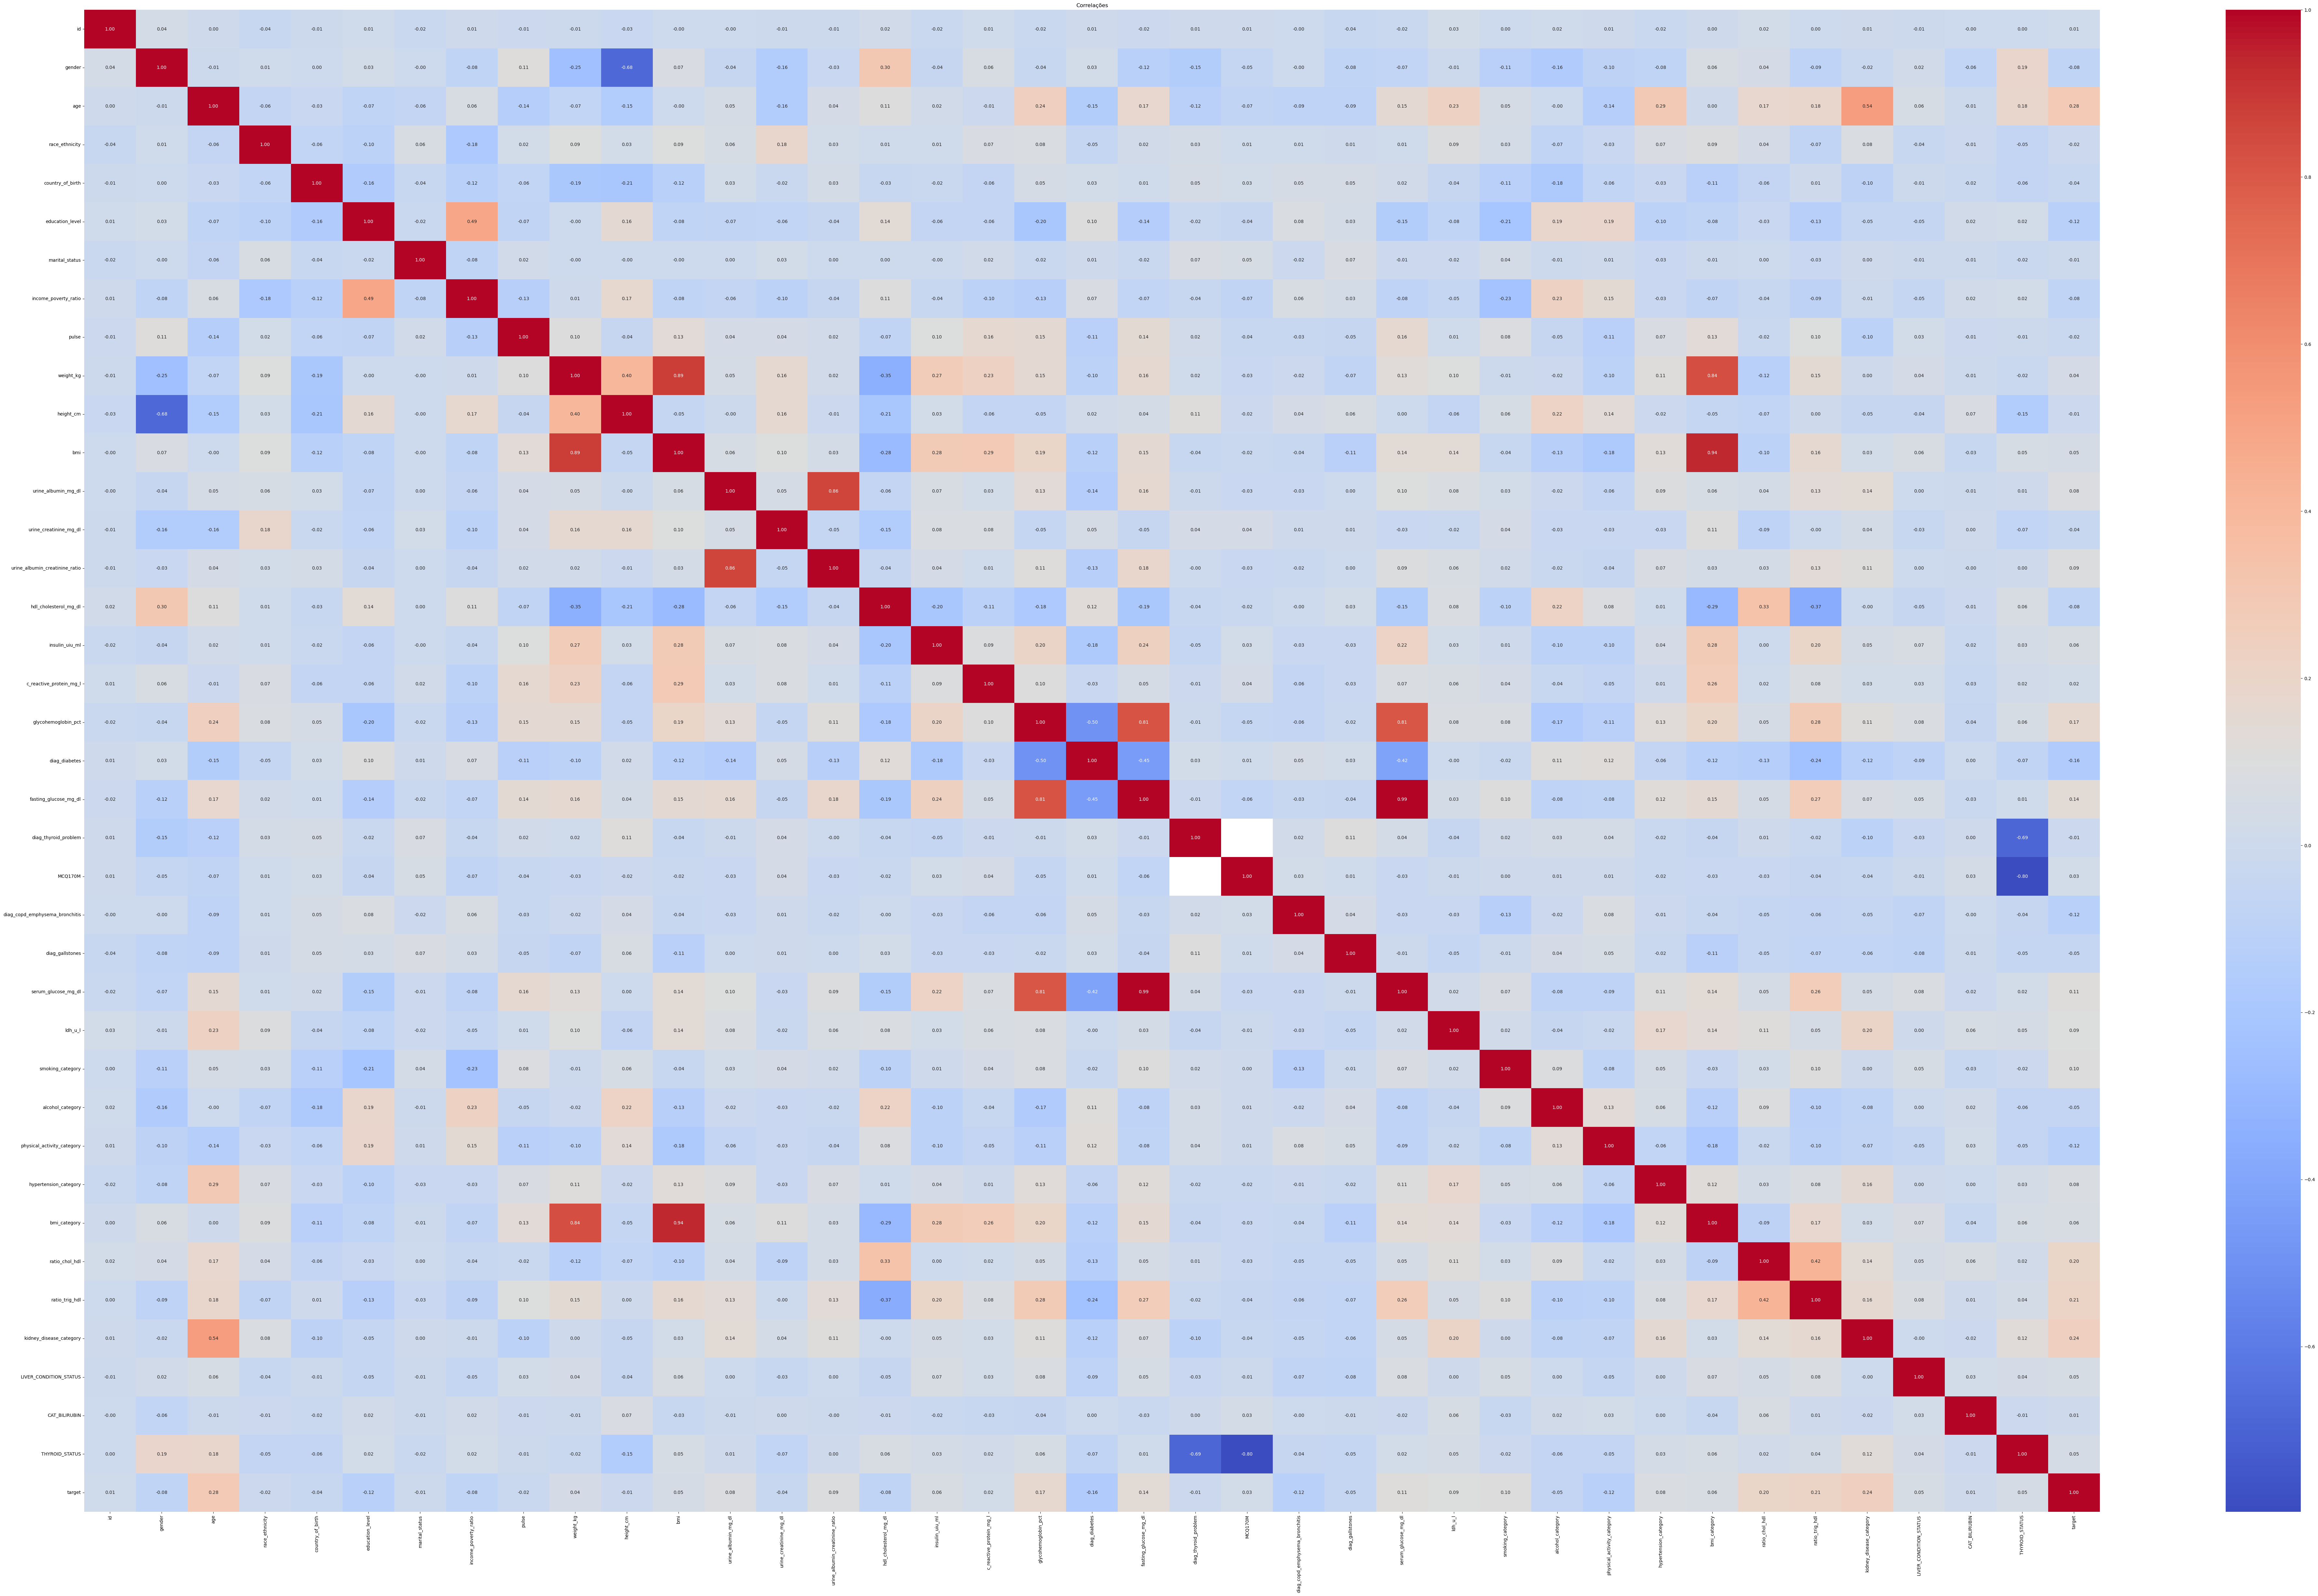

In [128]:
# The correlation Matrix will be generated after the removal of some columns to enable the comprehension of the studied data
# Attributes correlation matrix
corr = subset_cvd_df.corr(numeric_only=True)

plt.figure(figsize=(100, 60))

sns.heatmap(data=corr, annot=True, cmap='coolwarm', fmt=".2f")

plt.title('Correlações')

plt.show()

## Remoção de valores faltantes

In [129]:
print("Number of null values per column after processing:")
print(subset_cvd_df.isnull().sum().to_string())

Number of null values per column after processing:
id                                   0
gender                               0
age                                  0
race_ethnicity                       0
country_of_birth                    15
education_level                     14
marital_status                      15
income_poverty_ratio              1317
pulse                             1945
weight_kg                         1825
height_cm                         1811
bmi                               1838
urine_albumin_mg_dl               1898
urine_creatinine_mg_dl            1898
urine_albumin_creatinine_ratio    1898
hdl_cholesterol_mg_dl             2310
insulin_uiu_ml                    4738
c_reactive_protein_mg_l           2214
glycohemoglobin_pct               2041
diag_diabetes                        1
fasting_glucose_mg_dl             4598
diag_thyroid_problem                 1
MCQ170M                           6753
diag_copd_emphysema_bronchitis       1
diag_gallston

In [130]:
# import pandas as pd
# import numpy as np
#
# # Identify numerical and categorical columns with missing values
# numerical_cols = subset_cvd_df.select_dtypes(include=np.number).columns
# categorical_cols = subset_cvd_df.select_dtypes(include='object').columns
#
# print("Filling missing numerical values with median...")
# for col in numerical_cols:
#     if subset_cvd_df[col].isnull().any():
#         median_val = subset_cvd_df[col].median()
#         subset_cvd_df.fillna({col: median_val}, inplace=True)
#         print(f"  Filled '{col}' with median: {median_val}")
#
# print("\nFilling missing categorical values with mode...")
# for col in categorical_cols:
#     if subset_cvd_df[col].isnull().any():
#         # Mode might return multiple values if they have the same frequency, take the first one
#         mode_val = subset_cvd_df[col].mode()[0]
#         subset_cvd_df[col].fillna(mode_val, inplace=True)
#         print(f"  Filled '{col}' with mode: {mode_val}")
#
# print("\nMissing values after imputation:")
# print(subset_cvd_df.isnull().sum().sum())
#
# subset_cvd_df.info()

In [131]:
print("Number of null values per column after processing:")
print(subset_cvd_df.isnull().sum())

Number of null values per column after processing:
id                                   0
gender                               0
age                                  0
race_ethnicity                       0
country_of_birth                    15
education_level                     14
marital_status                      15
income_poverty_ratio              1317
pulse                             1945
weight_kg                         1825
height_cm                         1811
bmi                               1838
urine_albumin_mg_dl               1898
urine_creatinine_mg_dl            1898
urine_albumin_creatinine_ratio    1898
hdl_cholesterol_mg_dl             2310
insulin_uiu_ml                    4738
c_reactive_protein_mg_l           2214
glycohemoglobin_pct               2041
diag_diabetes                        1
fasting_glucose_mg_dl             4598
diag_thyroid_problem                 1
MCQ170M                           6753
diag_copd_emphysema_bronchitis       1
diag_gallston

In [132]:
subset_cvd_df.drop(columns=['country_of_birth', 'marital_status', 'MCQ170M', 'diag_copd_emphysema_bronchitis', 'diag_gallstones'], inplace=True)

subset_cvd_df.dropna(inplace=True)

subset_cvd_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1666 entries, 1 to 7800
Data columns (total 34 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1666 non-null   float64
 1   gender                          1666 non-null   float64
 2   age                             1666 non-null   float64
 3   race_ethnicity                  1666 non-null   int64  
 4   education_level                 1666 non-null   float64
 5   income_poverty_ratio            1666 non-null   float64
 6   pulse                           1666 non-null   float64
 7   weight_kg                       1666 non-null   float64
 8   height_cm                       1666 non-null   float64
 9   bmi                             1666 non-null   float64
 10  urine_albumin_mg_dl             1666 non-null   float64
 11  urine_creatinine_mg_dl          1666 non-null   float64
 12  urine_albumin_creatinine_ratio  1666 no

# Treinamento

## Importando bibliotecas necessárias para treinamento e avaliação dos models

In [133]:
# GPU variant
%conda install -c conda-forge py-xgboost=*=cuda*

2 channel Terms of Service accepted
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [134]:
# Importing helpers, metrics e and models
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, roc_curve, \
    roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_graphviz
import graphviz
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
%pip install imbalanced-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Imports de ML
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
# Pipeline e models Scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, \
    roc_auc_score
from scipy.stats import uniform, randint
%pip install aif360

# Imports para SMOTE e o Pipeline correto
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline  # Importante! Use o Pipeline do imblearn
from aif360.sklearn import metrics as mt


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [135]:
resultados = []
resultados

[]

In [136]:
cnf_matrices = []
cnf_matrices

[]

In [137]:
curvas_roc = []
curvas_roc

[]

In [138]:
bias_analysis = []
bias_analysis

[]

## Divisão dos dados e Treinamento dos models

In [139]:
# Create a crosstab of target and race_ethnicity
# The 'target' column is the CVD status (0: No CVD, 1: CVD)
# The 'race_ethnicity' column represents different race/ethnicity groups
# We use normalize='index' to show the proportion of target=1 within each race_ethnicity group
race_ethnicity_target_incidence = pd.crosstab(
    subset_cvd_df['race_ethnicity'],
    subset_cvd_df['target'],
    normalize='index'  # Normalizes across rows, showing proportion within each race/ethnicity
)

# Rename columns for clarity
race_ethnicity_target_incidence.columns = ['No CVD (%)', 'CVD (%)']

# Display the table
print("Incidência de Doença Cardiovascular por Raça/Etnia:")
display(race_ethnicity_target_incidence)

Incidência de Doença Cardiovascular por Raça/Etnia:


No CVD (%)   CVD (%)
race_ethnicity                      
0                 0.915894  0.084106
1                 0.903846  0.096154

In [140]:
# Count individuals with target=1 (CVD) for each race_ethnicity
cvd_by_race = subset_cvd_df[subset_cvd_df['target'] == 1]['race_ethnicity'].value_counts().sort_index()
cvd1_by_race = subset_cvd_df[subset_cvd_df['target'] == 0]['race_ethnicity'].value_counts().sort_index()

print("Number of individuals with CVD (target=1) by Race/Ethnicity:")
display(cvd_by_race)
display(cvd1_by_race)

Number of individuals with CVD (target=1) by Race/Ethnicity:


race_ethnicity
0    127
1     15
Name: count, dtype: int64

race_ethnicity
0    1383
1     141
Name: count, dtype: int64

In [141]:
# Holdout with Cross Validation: 70% for Training and Cross Validation, 30% for final test

X = subset_cvd_df.drop(columns=['target'])
y = subset_cvd_df['target']

X_train_cv, X_test_final, y_train_cv, y_test_final = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Tamanho do conjunto para CV (70%): {X_train_cv.shape}")
print(f"Tamanho do conjunto de Teste Final (30%): {X_test_final.shape}")

Tamanho do conjunto para CV (70%): (1166, 33)
Tamanho do conjunto de Teste Final (30%): (500, 33)


In [ ]:
best_models = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),
        ('model', LogisticRegression(
            C=np.float64(2.4415966431453837),
            penalty='l1',
            solver='liblinear',
            max_iter=1000,
            random_state=42
        ))
    ]),
    "KNN": Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier(
            n_neighbors=3,
            p=2,
            weights='distance'
        ))
    ]),
    "Decision Tree": Pipeline([
        ('model', DecisionTreeClassifier(
            criterion='gini',
            max_depth=5,
            min_samples_leaf=6,
            random_state=42
        ))
    ]),
    "Random Forest": Pipeline([
        ('model', RandomForestClassifier(
            n_estimators=300,
            max_depth=5,
            max_features='log2',
            min_samples_leaf=4,
            random_state=42,
            n_jobs=-1
        ))
    ]),
    "Gradient Boosting": Pipeline([
        ('model', GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=np.float64(0.18533072053166902),
            max_depth=3,
            random_state=42
        ))
    ])
}
# Logistic Regression:
#   **Best F1-Score:** 0.3561
#   **Best Hyperparams:** {'model__C': np.float64(2.4415966431453837), 'model__penalty': 'l1'}

# KNN:
#   **Best F1-Score:** 0.1760
#   **Best Hyperparams:** {'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'distance'}

# Decision Tree:
#   **Best F1-Score:** 0.3476
#   **Best Hyperparams:** {'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 6}

# Random Forest:
#   **Best F1-Score:** 0.4067
# ...

# Gradient Boosting:
#   **Best F1-Score:** 0.2808
#   **Best Hyperparams:** {'model__learning_rate': np.float64(0.18533072053166902), 'model__max_depth': 3, 'model__n_estimators': 100}

## Optimizing models hyperparameters
After a run with a iteration number of 500 and focusing in the best F1-Score value, we got the following best models:
- Logistic Regression:
    -   **Best F1:** 0.3561
    -   **Best Hyperparams:** {'model__C': np.float64(2.4415966431453837), 'model__penalty': 'l1'}
- KNN:
    -   **Best F1:** 0.1760
    -   **Best Hyperparams:** {'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'distance'}
- Decision Tree:
    -   **Best F1:** 0.3476
    -   **Best Hyperparams:** {'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 6}
- Random Forest:
    -   **Best F1:** 0.4067
    -   **Best Hyperparams:** {'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__n_estimators': 300}
- Gradient Boosting:
    -   **Best F1:** 0.2808
    -   **Best Hyperparams:** {'model__learning_rate': np.float64(0.18533072053166902), 'model__max_depth': 3, 'model__n_estimators': 100}

In [143]:
best_models = {}
cv_results = {}

# Defining the base pipelines using scaler, if needed, and the models
pipelines = {
    "Logistic Regression": Pipeline([
        ('scaler', StandardScaler()),      # scaling
        ('model', LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'))
    ]),
    "KNN": Pipeline([
        ('scaler', StandardScaler()),
        ('model', KNeighborsClassifier())
    ]),
    "Decision Tree": Pipeline([
        ('model', DecisionTreeClassifier(random_state=42, class_weight='balanced'))
    ]),
    "Random Forest": Pipeline([
        ('model', RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced'))
    ]),
    "Gradient Boosting": Pipeline([
        ('model', GradientBoostingClassifier(random_state=42))
        # ('model', XGBRegressor(
        #     tree_method="hist",
        #     # predictor="gpu_predictor",
        #     device="cpu",
        #     n_jobs=-1
        # ))
    ])
}

# Hyperparameters grids
param_grids = {
    "Logistic Regression": {
        'model__penalty': ['l1', 'l2'],
        'model__C': uniform(0.01, 100)
    },
    "KNN": {
        'model__n_neighbors': randint(3, 21),
        'model__weights': ['uniform', 'distance'],
        'model__p': [1, 2]
    },
    "Decision Tree": {
        'model__max_depth': [3, 5, 7, 10, None],
        'model__min_samples_leaf': randint(1, 10),
        'model__criterion': ['gini', 'entropy']
    },
    "Random Forest": {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [5, 10, None],
        'model__min_samples_leaf': randint(1, 5),
        'model__max_features': ['sqrt', 'log2']
    },
    "Gradient Boosting": {
        'model__n_estimators': [100, 200],
        'model__learning_rate': uniform(0.01, 0.2),
        'model__max_depth': [3, 5, 7]
    }
}

# Cross validation with optimization loop (RandomizedSearchCV)
cv_folds = 5
skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)

for nome, model in pipelines.items():
    print(f"Optimizing: {nome}...")
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[nome],
        n_iter=500,
        cv=skf,
        scoring='f1',
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train_cv, y_train_cv)
    best_models[nome] = search.best_estimator_
    cv_results[nome] = {
        "Best F1-Score (CV)": search.best_score_,
        "Best Hyperparams": search.best_params_
    }
    print(f"{nome}: Best F1-Score (CV) = {search.best_score_:.4f}")

# Cross validation results
for nome, result in cv_results.items():
    print(f"\n{nome}:")
    print(f"  **Best F1-Score:** {result['Best F1-Score (CV)']:.4f}")
    print(f"  **Best Hyperparams:** {result['Best Hyperparams']}")

Optimizing: Logistic Regression...
Logistic Regression: Best F1-Score (CV) = 0.3561
Optimizing: KNN...
KNN: Best F1-Score (CV) = 0.1760
Optimizing: Decision Tree...
Decision Tree: Best F1-Score (CV) = 0.3476
Optimizing: Random Forest...
Random Forest: Best F1-Score (CV) = 0.4067
Optimizing: Gradient Boosting...
Gradient Boosting: Best F1-Score (CV) = 0.2808

Logistic Regression:
  **Best F1-Score:** 0.3561
  **Best Hyperparams:** {'model__C': np.float64(2.4415966431453837), 'model__penalty': 'l1'}

KNN:
  **Best F1-Score:** 0.1760
  **Best Hyperparams:** {'model__n_neighbors': 3, 'model__p': 2, 'model__weights': 'distance'}

Decision Tree:
  **Best F1-Score:** 0.3476
  **Best Hyperparams:** {'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 6}

Random Forest:
  **Best F1-Score:** 0.4067
  **Best Hyperparams:** {'model__max_depth': 5, 'model__max_features': 'log2', 'model__min_samples_leaf': 4, 'model__n_estimators': 300}

Gradient Boosting:
  **Best F1-Score

Acurácia  Precisão    Recall  F1-Score       AUC
Model                                                                
Logistic Regression     0.758  0.185484  0.534884  0.275449  0.712483
KNN                     0.896  0.090909  0.023256  0.037037  0.556511
Decision Tree           0.704  0.147651  0.511628  0.229167  0.607348
Random Forest           0.846  0.196429  0.255814  0.222222  0.740420
Gradient Boosting       0.902  0.333333  0.139535  0.196721  0.740471

<Figure size 1200x600 with 0 Axes>

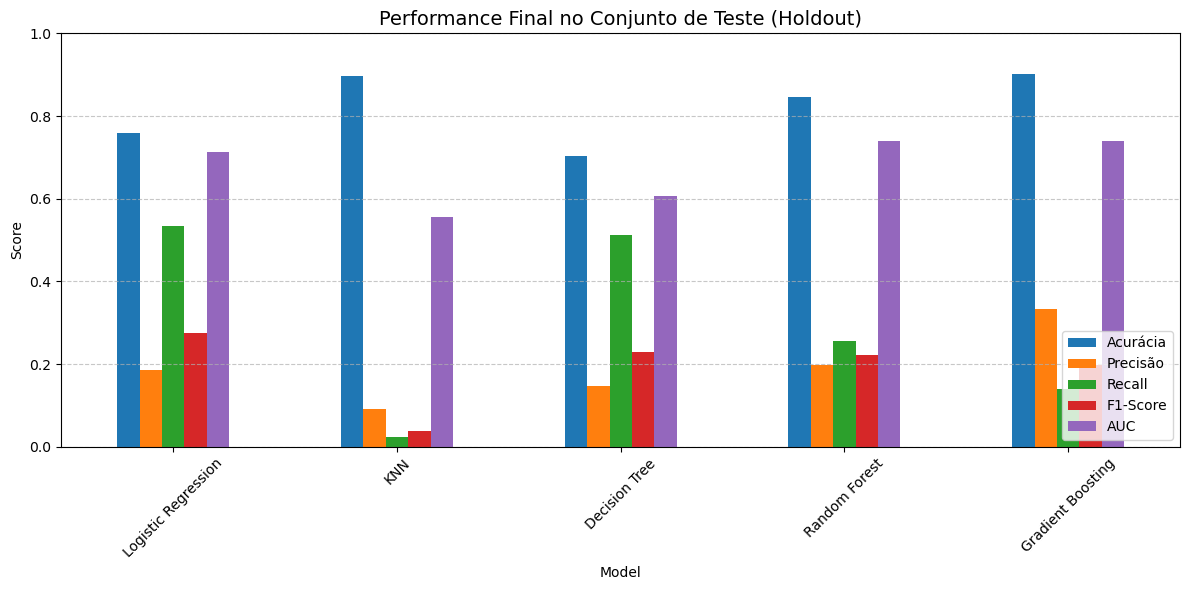

In [144]:
# Final validation with test set
for nome, model in best_models.items():
    model.fit(X_train_cv, y_train_cv)

    y_pred_final = model.predict(X_test_final)

    if hasattr(model, "predict_proba"):
        y_prob_final = model.predict_proba(X_test_final)[:, 1]
    else:
        y_prob_final = y_pred_final

    roc_auc = roc_auc_score(y_test_final, y_prob_final)
    fpr, tpr, thresholds = roc_curve(y_test_final, y_prob_final)

    curvas_roc.append({"Model": nome, "FPR": fpr, "TPR": tpr, "Thresholds": thresholds, "AUC": roc_auc})
    cnf_matrices.append({"Model": nome, "Matriz de confusão": confusion_matrix(y_test_final, y_pred_final)})
    resultados.append({
        "Model": nome,
        "Acurácia": accuracy_score(y_test_final, y_pred_final),
        "Precisão": precision_score(y_test_final, y_pred_final),
        "Recall": recall_score(y_test_final, y_pred_final),
        "F1-Score": f1_score(y_test_final, y_pred_final),
        "AUC": roc_auc
    })
    bias_analysis.append({
        "Model": nome,
        "predicted_result": y_pred_final,
        "real_result": y_test_final
    })

# Show results in a table
df_teste_final = pd.DataFrame(resultados).set_index("Model")
display(df_teste_final)

# Show results in a graph
plt.figure(figsize=(12, 6))
df_teste_final[['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'AUC']].plot(kind="bar", figsize=(12, 6))
plt.title("Performance Final no Conjunto de Teste (Holdout)", fontsize=14)
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

## Bias Analysis

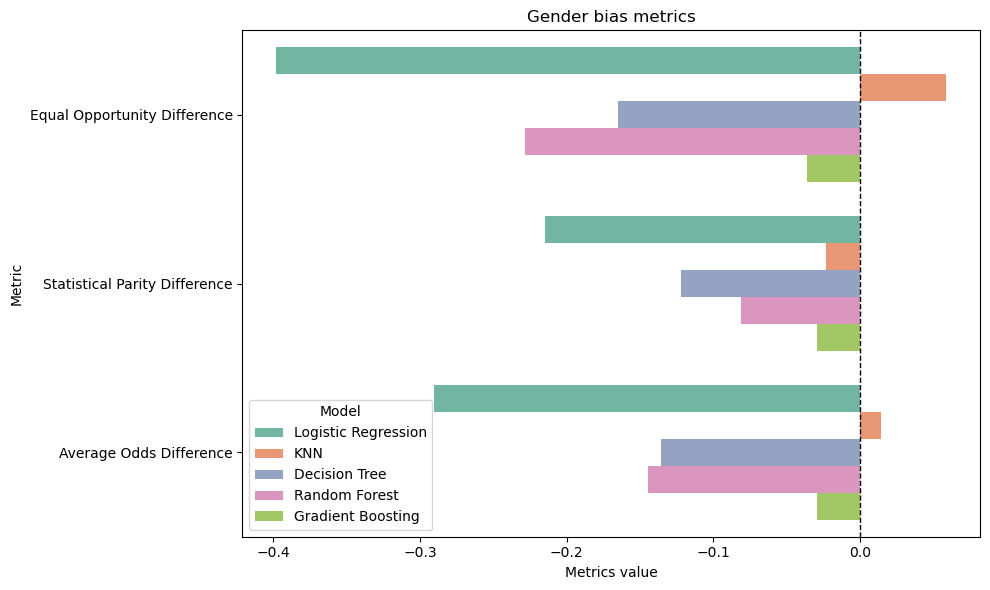

In [145]:
# Gender bias analysis
prot_gender = X_test_final['gender']
results = []

for model_bias_analysis in bias_analysis:
    model_name = model_bias_analysis['Model']
    predicted_result = model_bias_analysis['predicted_result']
    real_result = model_bias_analysis['real_result']

    eod = mt.equal_opportunity_difference(real_result, predicted_result, prot_attr=prot_gender)
    spd = mt.statistical_parity_difference(real_result, predicted_result, prot_attr=prot_gender)
    aod = mt.average_odds_difference(real_result, predicted_result, prot_attr=prot_gender)

    results.append({
        'Model': model_name,
        'Equal Opportunity Difference': eod,
        'Statistical Parity Difference': spd,
        'Average Odds Difference': aod
    })

bias_df = pd.DataFrame(results)

# --- Transform data for plotting ---
bias_df_melted = bias_df.melt(
    id_vars='Model',
    var_name='Métrica',
    value_name='Valor'
)

# --- Plot horizontally with 0 in the center ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=bias_df_melted,
    y='Métrica',
    x='Valor',
    hue='Model',
    orient='h',
    palette='Set2'
)

# Add vertical line at 0
plt.axvline(0, color='black', linewidth=1, linestyle='--')

# Negative values means the less privileged group is being more favorable
plt.title("Gender bias metrics")
plt.xlabel("Metrics value")
plt.ylabel("Metric")

plt.tight_layout()
plt.show()

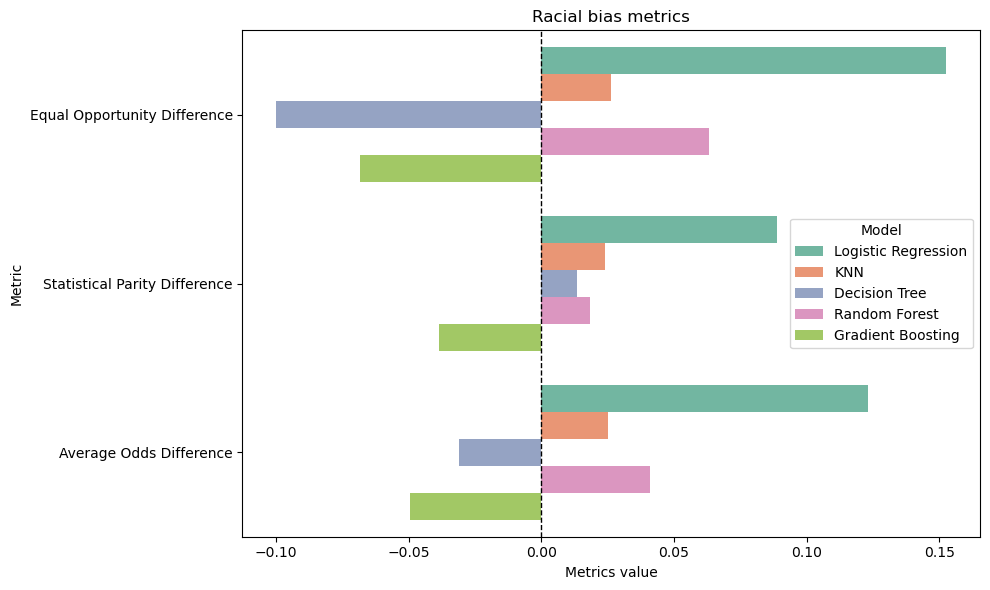

In [146]:
# Race bias analysis
prot_race = X_test_final['race_ethnicity']
results = []

for model_bias_analysis in bias_analysis:
    model_name = model_bias_analysis['Model']
    predicted_result = model_bias_analysis['predicted_result']
    real_result = model_bias_analysis['real_result']

    eod = mt.equal_opportunity_difference(real_result, predicted_result, prot_attr=prot_race)
    spd = mt.statistical_parity_difference(real_result, predicted_result, prot_attr=prot_race)
    aod = mt.average_odds_difference(real_result, predicted_result, prot_attr=prot_race)

    results.append({
        'Model': model_name,
        'Equal Opportunity Difference': eod,
        'Statistical Parity Difference': spd,
        'Average Odds Difference': aod
    })

bias_df = pd.DataFrame(results)

# --- Transform data for plotting ---
bias_df_melted = bias_df.melt(
    id_vars='Model',
    var_name='Métrica',
    value_name='Valor'
)

# --- Plot horizontally with 0 in the center ---
plt.figure(figsize=(10, 6))
sns.barplot(
    data=bias_df_melted,
    y='Métrica',
    x='Valor',
    hue='Model',
    orient='h',
    palette='Set2'
)

# Add vertical line at 0
plt.axvline(0, color='black', linewidth=1, linestyle='--')

# Negative values means the less privileged group is being more favorable
plt.title("Racial bias metrics")
plt.xlabel("Metrics value")
plt.ylabel("Metric")

plt.tight_layout()
plt.show()

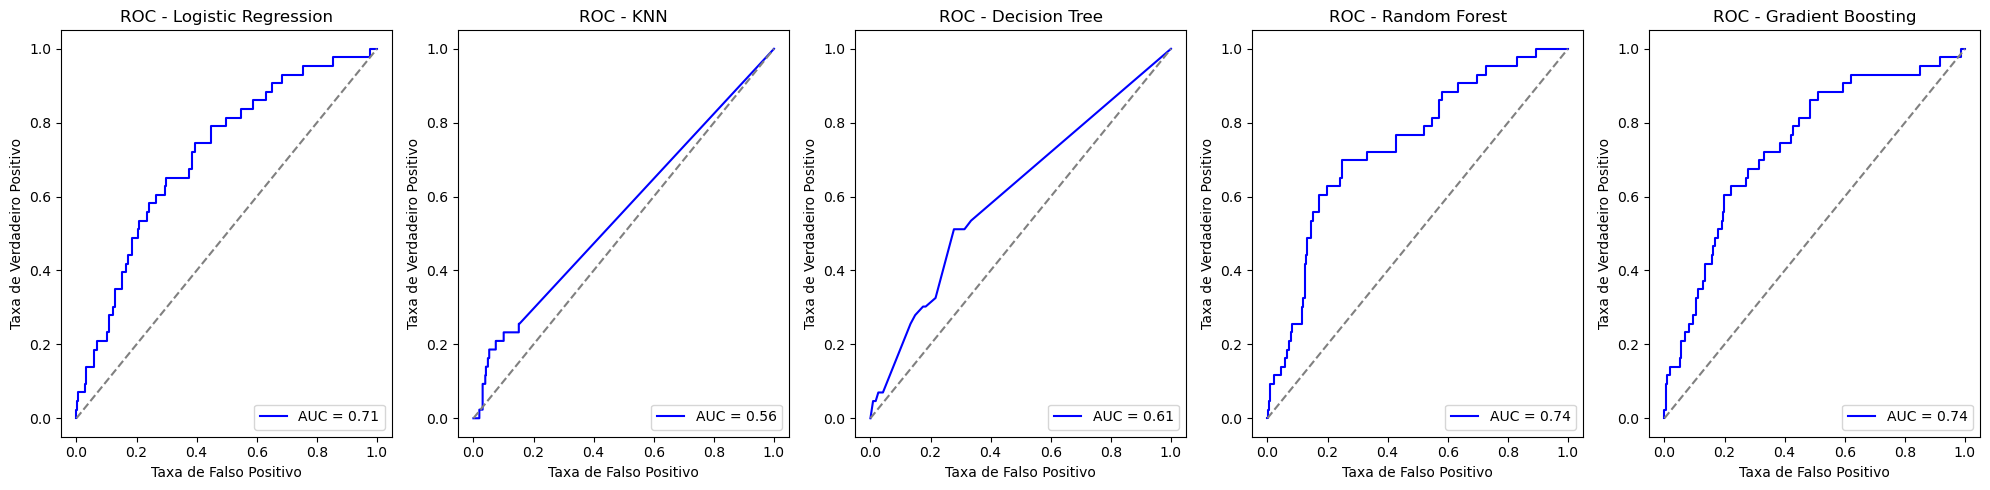

In [147]:
# Curvas ROC
# Subplots: um para cada model
fig, axes = plt.subplots(nrows=1, ncols=len(curvas_roc), figsize=(20, 5))
axes = axes.flatten()

# Plotar cada curva ROC
for i, curva in enumerate(curvas_roc):
    fpr = curva["FPR"]
    tpr = curva["TPR"]
    auc = curva["AUC"]
    nome = curva["Model"]

    axes[i].plot(fpr, tpr, color='blue', label=f"AUC = {auc:.2f}")
    axes[i].plot([0, 1], [0, 1], color='gray', linestyle='--')  # linha diagonal
    axes[i].set_title(f"ROC - {nome}")
    axes[i].set_xlabel("Taxa de Falso Positivo")
    axes[i].set_ylabel("Taxa de Verdadeiro Positivo")
    axes[i].legend(loc="lower right")

plt.tight_layout()
plt.show()


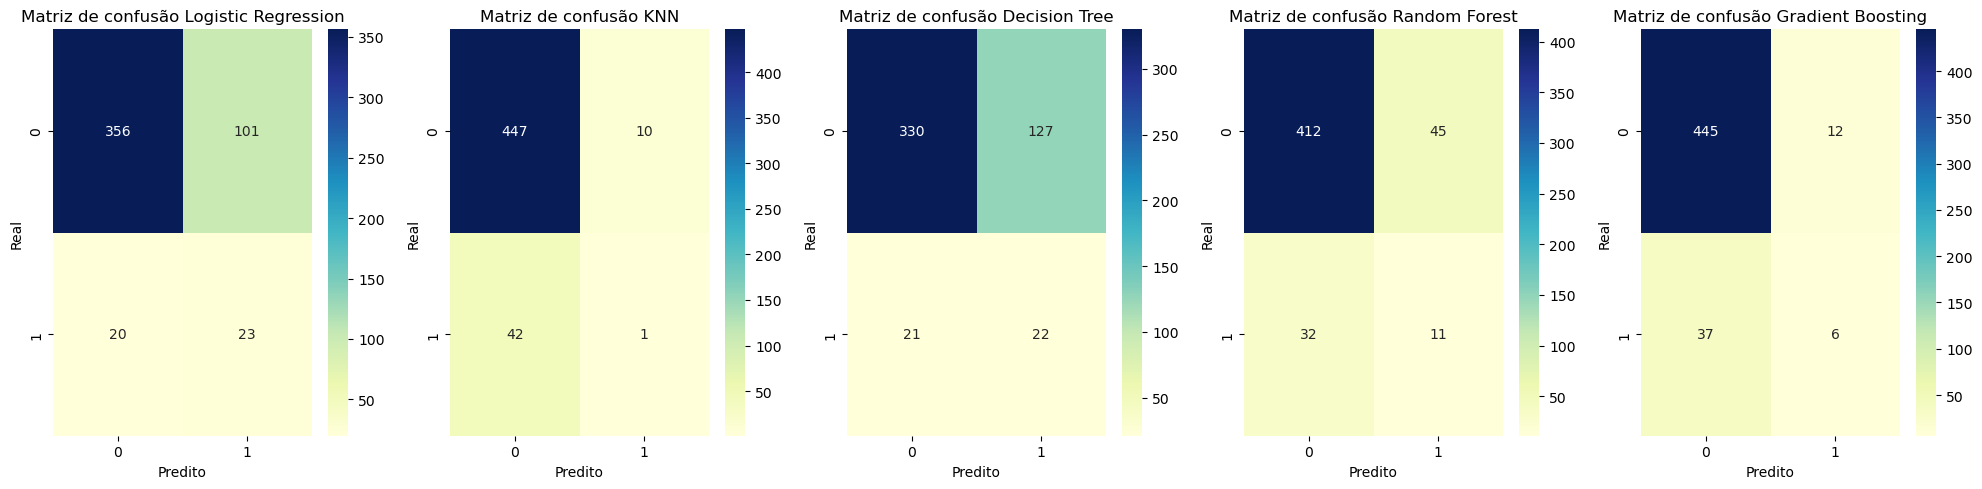

In [148]:
# Matrizes de confusão
# Definir número de subplots
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))
axes = axes.flatten()

# Criar os heatmaps
for i, cnf_matrix in enumerate(cnf_matrices):
    sns.heatmap(pd.DataFrame(cnf_matrix['Matriz de confusão']), annot=True, cmap="YlGnBu", fmt='g', ax=axes[i])
    axes[i].set_title(f"Matriz de confusão {cnf_matrix['Model']}")
    axes[i].set_xlabel("Predito")
    axes[i].set_ylabel("Real")

# Ajustar layout
plt.tight_layout()
plt.show()

## Interpretability
In this section we will use methods to understand how some of the models work:
- SHAP: Global Interpretability
- LIME: Local Interpretability
- Plotted Decision Tree: Model Intrinsic Interpretability

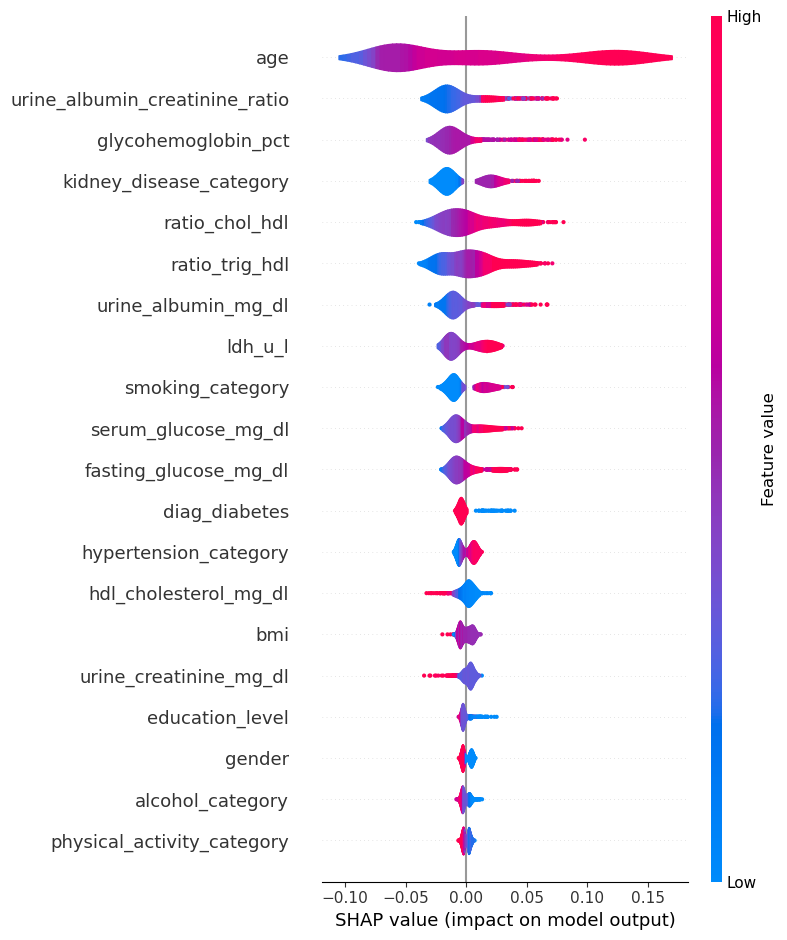

In [149]:
# SHAP for Random Forest

rf_pipeline = best_models['Random Forest']

rf_model = rf_pipeline.named_steps['model']

# 2. Create the TreeExplainer
explainer_rf = shap.TreeExplainer(rf_model, X_train_cv)

shap_values_rf = explainer_rf(X_test_final)

# Feature Importance Global
shap.summary_plot(shap_values_rf[..., 1], X_test_final, plot_type="violin")

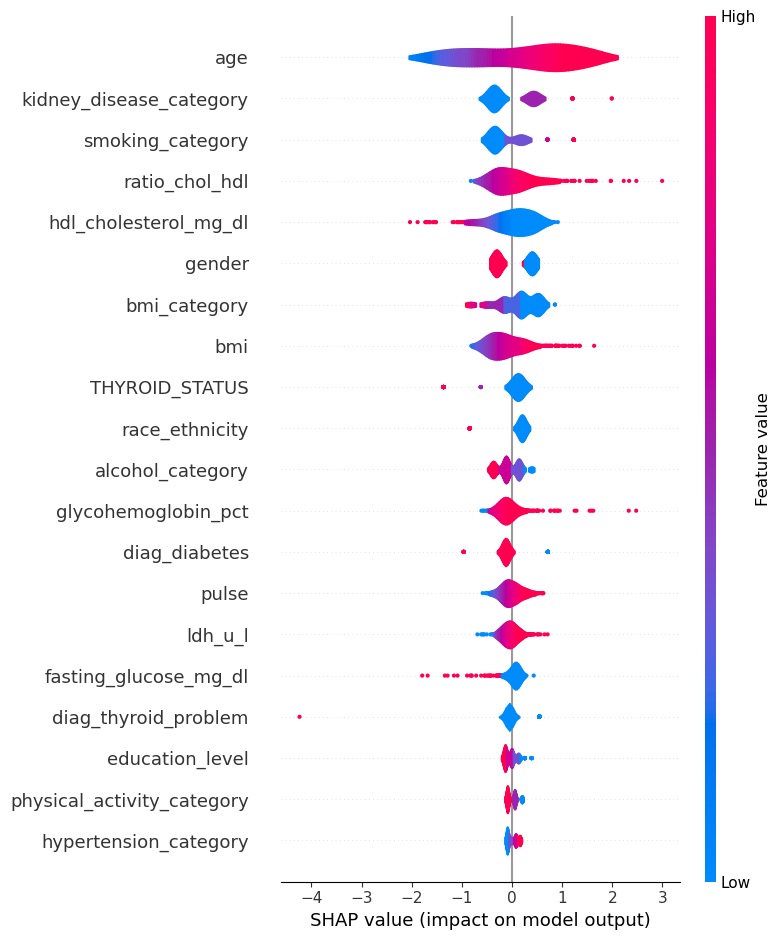

In [150]:
# SHAP for Logistic Regression

lr_pipeline = best_models['Logistic Regression']

lr_scaler = lr_pipeline.named_steps['scaler']
lr_model = lr_pipeline.named_steps['model']

X_train_cv_scaled = lr_scaler.transform(X_train_cv)
X_test_final_scaled = lr_scaler.transform(X_test_final)

explainer_lr = shap.LinearExplainer(lr_model, X_train_cv_scaled,
                                    feature_names=X.columns.tolist())

shap_values_lr = explainer_lr(X_test_final_scaled)

# Feature Importance Global
shap.summary_plot(shap_values_lr, X_test_final_scaled,
                  feature_names=X.columns.tolist(), plot_type="violin")

In [151]:
# Create a tabular LIME explainer, it needs the original data (before scaling) to learn the features importance
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_cv.values,  # LIME works betters numpy arrays
    feature_names=X.columns.tolist(),
    class_names=['Não Tem CVD', 'Tem CVD'],
    mode='classification'
)

# Choose some instance to test, in this case the first patient
instance_to_explain = X_test_final.iloc[0]

# Number of features to be shown
lime_num_features = 10

In [152]:
# --- LIME for Random Forest ---
rf_pipeline = best_models['Random Forest']

lime_exp_rf = explainer_lime.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=rf_pipeline.predict_proba,
    num_features=lime_num_features
)

lime_exp_rf.show_in_notebook(show_table=True)

/home/brunorcorrea/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [153]:
# --- LIME for Logistic Regression ---
lr_pipeline = best_models['Logistic Regression']

lime_exp_lr = explainer_lime.explain_instance(
    data_row=instance_to_explain.values,
    predict_fn=lr_pipeline.predict_proba,
    num_features=lime_num_features
)

lime_exp_lr.show_in_notebook(show_table=True)

/home/brunorcorrea/miniconda3/envs/gpu_env/lib/python3.10/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [154]:
decision_tree_model = best_models['Decision Tree']['model']

plt.figure(figsize=(60, 30), dpi=200)
plot_tree(
    decision_tree_model,
    feature_names=X.columns,
    class_names=["Without CVD", "With CVD"],
    filled=True,
    rounded=True,
    fontsize=10
)
plt.tight_layout()
plt.savefig("decision_tree.png", dpi=300, bbox_inches="tight")
plt.show()


## Mitigating Bias

In [155]:
# --- Fairlearn Imports ---
# The mitigation algorithm
from fairlearn.reductions import ExponentiatedGradient, EqualizedOdds
# The evaluation metrics

from fairlearn.metrics import MetricFrame, selection_rate_difference, equalized_odds_difference

In [156]:
# RACE BIAS MITIGATION USING FAIRLEARN

# --- 1. Prepare Data for Fairlearn ---
# Fairlearn's mitigation algorithms need the sensitive features
# to be provided explicitly during the .fit() call.

# We MUST scale the data for Logistic Regression, as ExponentiatedGradient does not use an sklearn Pipeline.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_cv)
X_test_scaled = scaler.transform(X_test_final)

# Get the sensitive feature arrays (e.g., 'race_ethnicity' or 'gender')
# We must get them from the original 'subset_cvd_df' using the indices of our train/test splits.
sensitive_features_train = subset_cvd_df.loc[X_train_cv.index, 'race_ethnicity']
sensitive_features_test = subset_cvd_df.loc[X_test_final.index, 'race_ethnicity']

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Sensitive features train shape: {sensitive_features_train.shape}")

# --- 2. Define the Model and Constraint ---

# 2a. The Base Estimator: A standard sklearn model
# We use the best params from your 'Logistic Regression' search
# (Or just a default one to start)
base_model = best_models['Logistic Regression']['model']

# 2b. The Fairness Constraint:
# We choose 'EqualizedOdds' because it directly targets the 'Equal Opportunity Difference' (EOD) which was your main problem.
constraint = EqualizedOdds()

# --- 3. Train the Mitigated Model ---

print("\nStarting mitigation training (ExponentiatedGradient)...")
# ExponentiatedGradient trains many models to find the besttrade-off between accuracy and fairness.
mitigator = ExponentiatedGradient(
    estimator=base_model,
    constraints=constraint
)

# Fit the mitigator. It needs X, y, and sensitive_features
mitigator.fit(
    X_train_scaled, 
    y_train_cv, 
    sensitive_features=sensitive_features_train
)
print("Mitigation training complete.")

# --- 4. Evaluate the New Mitigated Model ---

# Make predictions with the new, "fair" model
y_pred_mitigated = mitigator.predict(X_test_scaled)

print("\n--- Mitigated Model Evaluation (on Test Set) ---")

# Fairlearn's 'MetricFrame' is the best way to see results
# It automatically calculates metrics for the overall model AND for each group.
metrics_mitigated = MetricFrame(
    metrics={
        'accuracy': accuracy_score,
        'recall (EOD)': recall_score,
        'f1_score': f1_score,
        'selection_rate (SPD)': lambda y_t, y_p: (y_p == 1).mean()
    },
    y_true=y_test_final,
    y_pred=y_pred_mitigated,
    sensitive_features=sensitive_features_test
)

print("\n--- Overall Metrics (Mitigated Model) ---")
print(metrics_mitigated.overall)

print("\n--- Metrics by Group (Mitigated Model) ---")
print(metrics_mitigated.by_group)

# --- 5. Show the Final Bias Scores (Corrected) ---
print("\n--- Final Bias Scores (Mitigated Model) ---")

# We will use the dedicated functions we imported,
# as they are cleaner and do exactly what we need.

spd = selection_rate_difference(
    y_test_final, 
    y_pred_mitigated, 
    sensitive_features=sensitive_features_test
)

eod = equalized_odds_difference(
    y_test_final, 
    y_pred_mitigated, 
    sensitive_features=sensitive_features_test
)

print(f"Statistical Parity Difference (SPD): {spd:.4f}")
print(f"Equal Opportunity Difference (EOD): {eod:.4f}")

Training data shape: (1166, 33)
Sensitive features train shape: (1166,)

Starting mitigation training (ExponentiatedGradient)...
Mitigation training complete.

--- Mitigated Model Evaluation (on Test Set) ---

--- Overall Metrics (Mitigated Model) ---
accuracy                0.818000
recall (EOD)            0.255814
f1_score                0.194690
selection_rate (SPD)    0.140000
dtype: float64

--- Metrics by Group (Mitigated Model) ---
                accuracy  recall (EOD)  f1_score  selection_rate (SPD)
race_ethnicity                                                        
0               0.816594      0.289474  0.207547              0.148472
1               0.833333      0.000000  0.000000              0.047619

--- Final Bias Scores (Mitigated Model) ---
Statistical Parity Difference (SPD): 0.1009
Equal Opportunity Difference (EOD): 0.2895


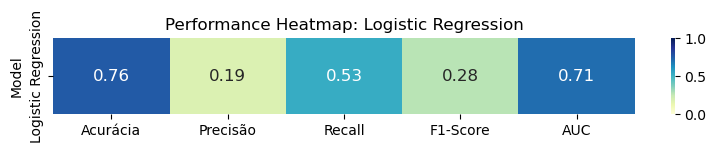

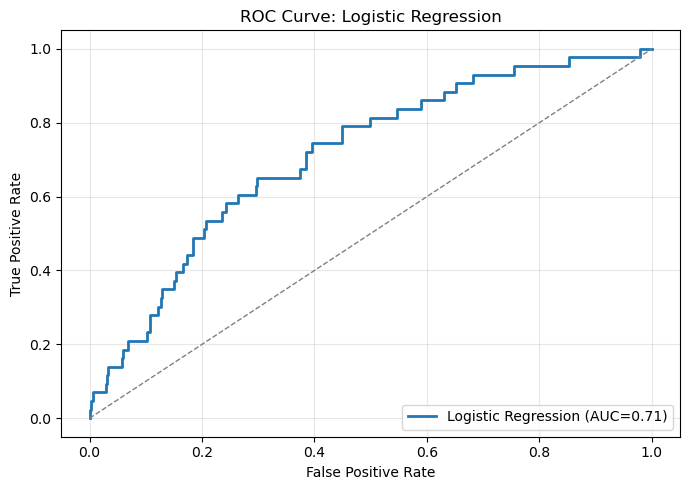

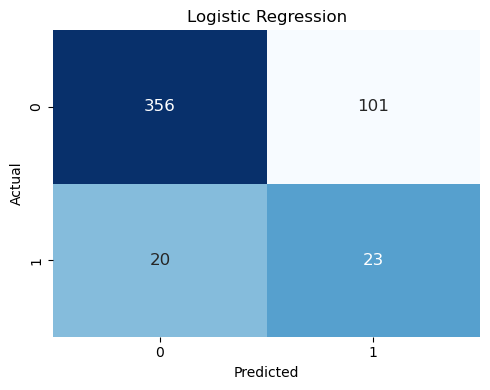

/tmp/ipykernel_2804/4035208717.py:123: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_gender_bias, x='Valor', y='Métrica', ax=axes[0], palette='Set2', orient='h')
/tmp/ipykernel_2804/4035208717.py:128: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_race_bias, x='Valor', y='Métrica', ax=axes[1], palette='Set2', orient='h')


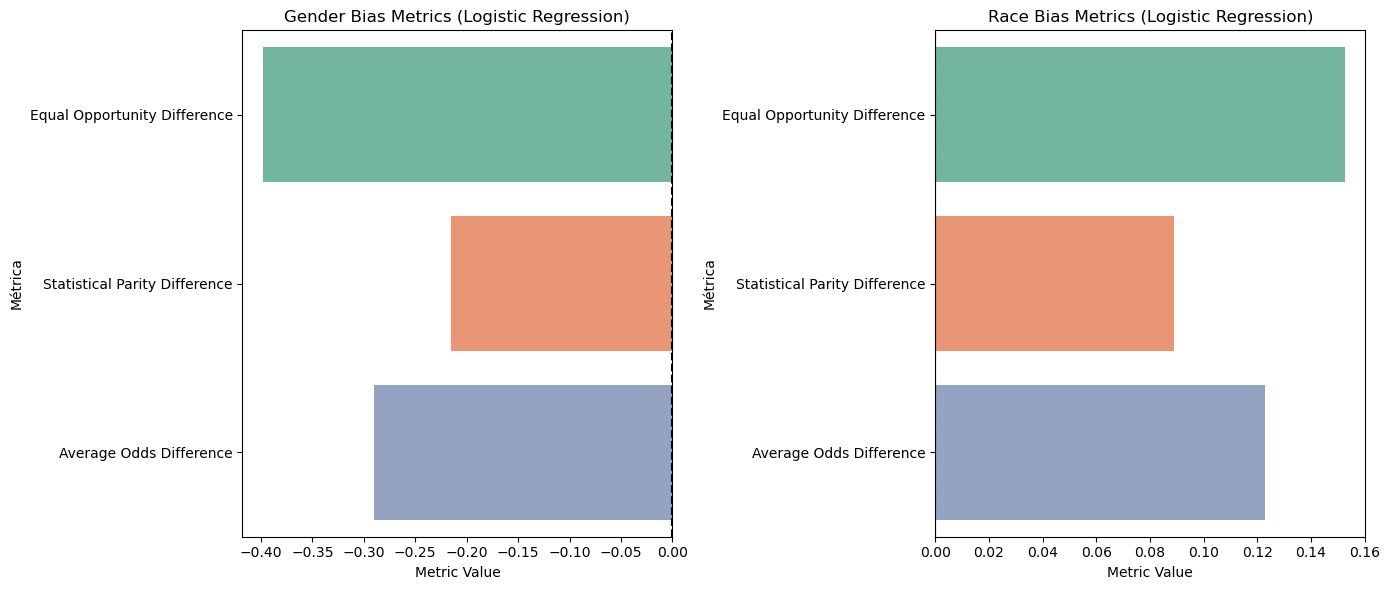

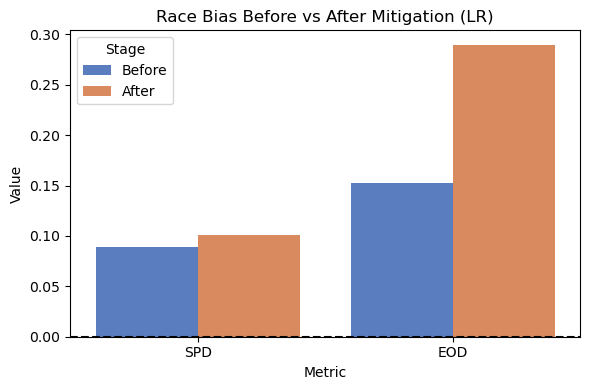

In [157]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import plotly.express as px
import math

# (Assuming all imports from your previous script are present)
# from sklearn.metrics import ...
# from aif360.sklearn import metrics as mt

# --- Define the single model we want to report on ---
TARGET_MODEL = "Logistic Regression" 
# (If your model name is in Portuguese, change to "Regressão Logística")

# --- 1) Performance summary (heatmap) ---
# Filter the results for only the model we want
try:
    df_perf = pd.DataFrame(resultados).set_index('Model')
    lr_perf = df_perf.loc[[TARGET_MODEL]] # Keep it as a DataFrame

    plt.figure(figsize=(8, 1.5)) # Smaller figure for a single row
    sns.heatmap(lr_perf[['Acurácia', 'Precisão', 'Recall', 'F1-Score', 'AUC']], 
                annot=True, cmap="YlGnBu", vmin=0, vmax=1,
                annot_kws={"size": 12})
    plt.title(f"Performance Heatmap: {TARGET_MODEL}")
    plt.tight_layout()
    plt.show()
except KeyError:
    print(f"Error: Could not find model '{TARGET_MODEL}' in 'resultados' list.")
except NameError:
    print("Skipping Plot 1: 'resultados' list not found.")


# --- 2) ROC Curve (single model) ---
try:
    # Find the ROC data for the specific model
    lr_roc_data = next(item for item in curvas_roc if item["Model"] == TARGET_MODEL)

    plt.figure(figsize=(7, 5))
    plt.plot(lr_roc_data["FPR"], lr_roc_data["TPR"], 
             label=f"{lr_roc_data['Model']} (AUC={lr_roc_data['AUC']:.2f})",
             linewidth=2)
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--', linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve: {TARGET_MODEL}")
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()
except StopIteration:
    print(f"Error: Could not find model '{TARGET_MODEL}' in 'curvas_roc' list.")
except NameError:
    print("Skipping Plot 2: 'curvas_roc' list not found.")


# --- 3) Confusion Matrix (single model) ---
try:
    # Find the confusion matrix for the specific model
    lr_cm_dict = next(item for item in cnf_matrices if item["Model"] == TARGET_MODEL)
    
    # Create a single subplot
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))

    cm = np.array(lr_cm_dict['Matriz de confusão'])
    # normalize per true label (rows)
    with np.errstate(all='ignore'):
        cm_norm = cm.astype(float) / cm.sum(axis=1, keepdims=True)
        
    sns.heatmap(cm_norm, annot=cm, fmt='g', cmap='Blues', cbar=False, ax=ax,
                annot_kws={"size": 12})
    ax.set_title(lr_cm_dict['Model'])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    
    plt.tight_layout()
    plt.show()
except StopIteration:
    print(f"Error: Could not find model '{TARGET_MODEL}' in 'cnf_matrices' list.")
except NameError:
    print("Skipping Plot 3: 'cnf_matrices' list not found.")


# --- 4) Bias metrics for Gender and Race (single model) ---
try:
    prot_gender = X_test_final['gender']
    prot_race = X_test_final['race_ethnicity']

    gender_results = []
    race_results = []

    # Find the bias data for the specific model
    lr_bias_data = next(item for item in bias_analysis if item["Model"] == TARGET_MODEL)
    
    name = lr_bias_data['Model']
    y_pred = lr_bias_data['predicted_result']
    y_true = lr_bias_data['real_result']

    # Gender metrics
    eod_g = mt.equal_opportunity_difference(y_true, y_pred, prot_attr=prot_gender)
    spd_g = mt.statistical_parity_difference(y_true, y_pred, prot_attr=prot_gender)
    aod_g = mt.average_odds_difference(y_true, y_pred, prot_attr=prot_gender)
    gender_results.append({'Model': name, 'Métrica': 'Equal Opportunity Difference', 'Valor': eod_g})
    gender_results.append({'Model': name, 'Métrica': 'Statistical Parity Difference', 'Valor': spd_g})
    gender_results.append({'Model': name, 'Métrica': 'Average Odds Difference', 'Valor': aod_g})

    # Race metrics
    eod_r = mt.equal_opportunity_difference(y_true, y_pred, prot_attr=prot_race)
    spd_r = mt.statistical_parity_difference(y_true, y_pred, prot_attr=prot_race)
    aod_r = mt.average_odds_difference(y_true, y_pred, prot_attr=prot_race)
    race_results.append({'Model': name, 'Métrica': 'Equal Opportunity Difference', 'Valor': eod_r})
    race_results.append({'Model': name, 'Métrica': 'Statistical Parity Difference', 'Valor': spd_r})
    race_results.append({'Model': name, 'Métrica': 'Average Odds Difference', 'Valor': aod_r})

    df_gender_bias = pd.DataFrame(gender_results)
    df_race_bias = pd.DataFrame(race_results)

    # --- 5) Plot bias metrics side-by-side (single model) ---
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # We removed 'hue="Model"' since there is only one
    sns.barplot(data=df_gender_bias, x='Valor', y='Métrica', ax=axes[0], palette='Set2', orient='h')
    axes[0].axvline(0, color='k', linestyle='--')
    axes[0].set_title(f"Gender Bias Metrics ({TARGET_MODEL})")
    axes[0].set_xlabel("Metric Value")

    sns.barplot(data=df_race_bias, x='Valor', y='Métrica', ax=axes[1], palette='Set2', orient='h')
    axes[1].axvline(0, color='k', linestyle='--')
    axes[1].set_title(f"Race Bias Metrics ({TARGET_MODEL})")
    axes[1].set_xlabel("Metric Value")

    plt.tight_layout()
    plt.show()

    # --- 6) Optional: show before/after mitigation ---
    # This plot now compares the 'unmitigated' Logistic Regression
    # to the 'mitigated' model (assuming 'y_pred_mitigated' exists)
    if 'y_pred_mitigated' in globals():
        # 'spd_r' and 'eod_r' were calculated above for the unmitigated model
        spd_before = spd_r
        eod_before = eod_r
        
        # Calculate 'after' metrics for the mitigated model
        spd_after = mt.statistical_parity_difference(y_test_final, y_pred_mitigated, prot_attr=prot_race)
        eod_after = mt.equal_opportunity_difference(y_test_final, y_pred_mitigated, prot_attr=prot_race)

        df_mitigation = pd.DataFrame([
            {'Metric': 'SPD', 'Stage': 'Before', 'Value': spd_before},
            {'Metric': 'SPD', 'Stage': 'After',  'Value': spd_after},
            {'Metric': 'EOD', 'Stage': 'Before', 'Value': eod_before},
            {'Metric': 'EOD', 'Stage': 'After',  'Value': eod_after}
        ])

        plt.figure(figsize=(6, 4))
        sns.barplot(data=df_mitigation, x='Metric', y='Value', hue='Stage', palette='muted')
        plt.title("Race Bias Before vs After Mitigation (LR)")
        plt.axhline(0, color='k', linestyle='--')
        plt.tight_layout()
        plt.show()

except StopIteration:
    print(f"Error: Could not find model '{TARGET_MODEL}' in 'bias_analysis' list.")
except NameError:
    print("Skipping Plots 4-6: 'bias_analysis' or 'X_test_final' list not found.")